# E-commerce

### Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 

The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.

You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

### Project Task: Week 1

#### Class Imbalance Problem:

    1. Perform an EDA on the dataset.

        *1.1 See what a positive, negative, and neutral review looks like

        *1.2 Check the class count for each class. It’s a class imbalance problem.

    2. Convert the reviews in Tf-Idf score.

    3. Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance.

#### Tackling Class Imbalance Problem:

    4. Oversampling or undersampling can be used to tackle the class imbalance problem. 

    5. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

    6. Use Tree-based classifiers like Random Forest and XGBoost.

#### Note: 
    Tree-based classifiers work on two ideologies namely, Bagging or Boosting and have fine-tuning parameter which takes care of the imbalanced class.

### Project Task: Week 2

#### Model Selection:

    1. Apply multi-class SVM’s and neural nets.

    2. Use possible ensemble techniques like: XGboost + oversampled_multinomial_NB.

    3. Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

#### Applying LSTM:

    4. Use LSTM for the previous problem (use parameters of LSTM like top-word, embedding-length, Dropout, epochs, number of layers, etc.)

   Hint: Another variation of LSTM, GRU (Gated Recurrent Units) can be tried as well.

    5. Compare the accuracy of neural nets with traditional ML based algorithms.

    6. Find the best setting of LSTM (Neural Net) and GRU that can best classify the reviews as positive, negative, and neutral. 

   Hint: Use techniques like Grid Search, Cross-Validation and Random Search

#### Topic Modeling:

    7. Cluster similar reviews.

   #### Note: 
    Some reviews may talk about the device as a gift-option. Other reviews may be about product looks and some may highlight about its battery and performance. Try naming the clusters.

    8. Perform Topic Modeling

   Hint: Use scikit-learn provided Latent Dirchlette Allocation (LDA) and Non-Negative Matrix Factorization (NMF).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import pickle
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, auc, confusion_matrix, f1_score, precision_score, roc_auc_score, make_scorer, roc_curve
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
import logging
from imblearn.over_sampling import SMOTE

import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import LdaModel
from gensim import corpora

from tqdm.auto import tqdm
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
import sweetviz

## A. Class Imbalance Problem

#### Import data

In [2]:
df_train = pd.read_csv('train_data.csv')
df_test  = pd.read_csv('test_data.csv')
df_test_hidden = pd.read_csv('test_data_hidden.csv')

In [3]:
# Print information
print('train shape ', df_train.shape)
print('test shape ', df_test.shape)
print('test hidden shape', df_test_hidden.shape)

train shape  (1402, 8)
test shape  (1000, 7)
test hidden shape (1000, 8)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1402 non-null   object
 1   brand              1402 non-null   object
 2   categories         1402 non-null   object
 3   primaryCategories  1402 non-null   object
 4   reviews.date       1402 non-null   object
 5   reviews.text       1402 non-null   object
 6   reviews.title      1401 non-null   object
 7   sentiment          1402 non-null   object
dtypes: object(8)
memory usage: 87.8+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
dtypes: object(7)
memory usage: 54.8+ KB


In [6]:
df_test_hidden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
 7   sentiment          1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [7]:
df_train.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1402,1402,1402,1402,1402,1402,1401,1402
unique,22,1,22,4,465,1402,1112,3
top,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2017-01-06T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,Great for kids,Positive
freq,417,1402,417,1127,43,1,32,1178


In [8]:
df_train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,"Nice tablet, simple to use",Positive
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-04T00:00:00.000Z,This is my second Kindle and I love it. It's l...,Everything you expect from Amazon,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,Tablet is perfect for beginners who just want ...,Ease of use,Positive
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,"Great quality, great price and best of all has...",Great deal,Positive


In [9]:
unique_classes = df_train['sentiment'].unique()
nb_classes = df_train['sentiment'].nunique()
print("Types of Unique Sentiments: ", unique_classes)
print("Number of unique sentiments: ", nb_classes)

Types of Unique Sentiments:  ['Positive' 'Neutral' 'Negative']
Number of unique sentiments:  3


In [10]:
test_report = sweetviz.analyze([df_train, 'amazon reviews information'])

                                             |          | [  0%]   00:00 -> (? left)

In [11]:
test_report.show_html('amazon_report.html')

Report amazon_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


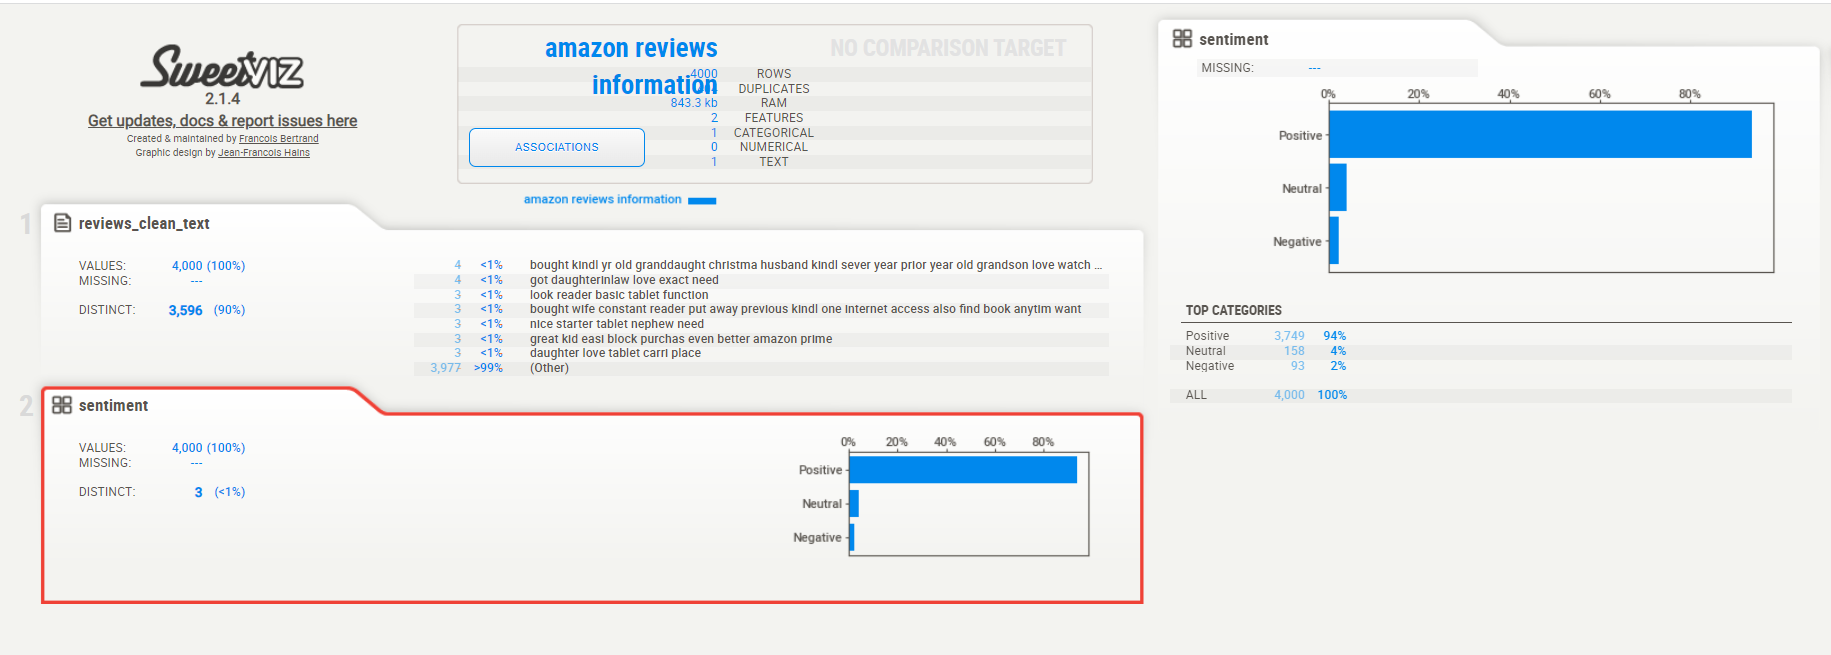

## 1. Perform an EDA on the dataset.

### 1.1 See what a positive, negative, and neutral review looks like

Checking Review samples for Positive, Negative and Neutral sentiments

In [12]:
# Positive Review sample
print('Positive Review Samples')
print(df_train[df_train['sentiment'] == 'Positive']['reviews.text'][0:2].values)

Positive Review Samples
['Great easy tablet for a reasonable price. Not the most super powerful. It can get the job done for simple tasks such as surfing the web, checking email, playing YouTube, etc. screen is clear and responsive. Great inexpensive tablet'
 "This is my second Kindle and I love it. It's lightweight, simple, and fast. It's convenient for trips and fits in my bag without weighing it down."]


In [13]:
# Negative Review sample
print('Negative Review Samples')
print(df_train[df_train['sentiment'] == 'Negative']['reviews.text'][0:2].values)

Negative Review Samples
['was cheap, can not run chrome stuff, returned to store.'
 'Worthless, except as a regular echo and a poor excuse for video chat. I love my echo devices, bathroom, pool, kitchen, other places where I may need hands free, voice activated music and info. My wife bought me the \'newest, hottest\' thing. I was skeptical but then thought I would use it to help on a project. Me "Alexa find videos on f450 drone" Alexa "YouTube is not available". Amazon won\'t directly sell chrome products, youtube won\'t play on echo show. Further testing shows the video call is more limited than iPhone or Android apps for video. So the most useful thing now is the same voice functions that my echos and dots perform. Unless I want to make all of my video calls and check the weather from a device I can move no more than 3 feet from an outlet.']


In [14]:
# Neutral Review sample
print('Neutral Review Samples')
print(df_train[df_train['sentiment'] == 'Neutral']['reviews.text'][:2].values)

Neutral Review Samples
['Just an average Alexa option. Does show a few things on screen but still limited.'
 "My 7-year old daughter saved up to by this. Her brother bought the 8GB about a year earlier, so new she needed more space. The OS is a bit clunky, and less intuitive then on higher priced tablets, but tough to beat the price. Speed isn't great for web or certain gaming apps, but fine for books. Parental controls are helpful, but take time to figure out and require more steps than seem necessary to change. Overall, OK first tablet for kids, considering the price. For adults, fine for e-books and VERY basic apps. Otherwise, best to pay up for better quality and OS efficiency."]


In [15]:
# Check for Null Values
df_train.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        1
sentiment            0
dtype: int64

Listing the Sentiment counts

In [16]:
# Listing the Sentiment counts
df_train['sentiment'].value_counts()

Positive    1178
Neutral      146
Negative      78
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

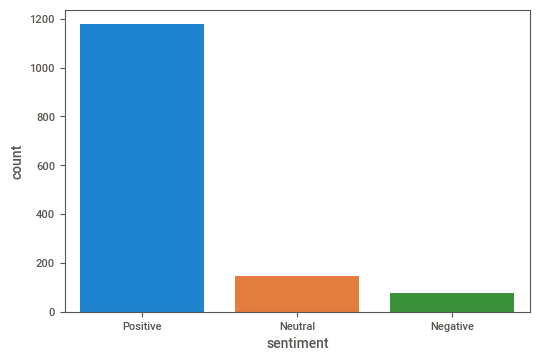

In [17]:
# Plotting the sentiment count 
sns.countplot(df_train['sentiment'])

From the above plot it is very clear that the given dataset is highly imbalance having more Positive reviews. If we use the dataset as it is it for modelling then it will not give us correct result and the results will be more tilted towards positive reviews. 
As a result we will have to consider the imbalance dataset into consideration and work on it to make it balance. 

#### Check the class count for each class. It’s a class imbalance problem.

In [18]:
# Getting columns names and its unique value counts
df_train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment'],
      dtype='object')

In [19]:
print('Unique Names            :',df_train['name'].nunique())
print('Unique brand            :',df_train['brand'].nunique())
print('Unique categories       :',df_train['categories'].nunique())
print('Unique primaryCategories:',df_train['primaryCategories'].nunique())
print('Unique reviews.date     :',df_train['reviews.date'].nunique())
print('Unique reviews.text     :',df_train['reviews.text'].nunique())
print('Unique reviews.title    :',df_train['reviews.title'].nunique())
print('Unique sentiment        :',df_train['sentiment'].nunique())



Unique Names            : 22
Unique brand            : 1
Unique categories       : 22
Unique primaryCategories: 4
Unique reviews.date     : 465
Unique reviews.text     : 1402
Unique reviews.title    : 1112
Unique sentiment        : 3


In [20]:
print('Unique primaryCategories:',df_train['primaryCategories'].unique())

Unique primaryCategories: ['Electronics' 'Electronics,Hardware' 'Office Supplies,Electronics'
 'Electronics,Media']


<AxesSubplot:xlabel='primaryCategories', ylabel='count'>

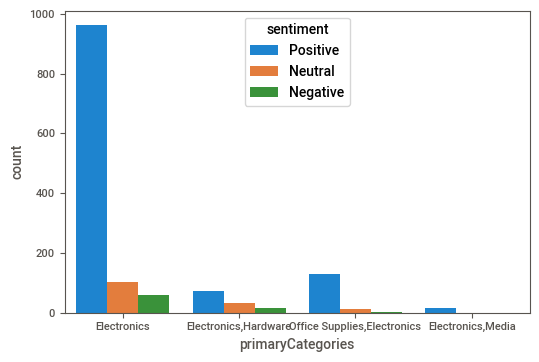

In [21]:
sns.countplot(data=df_train, x='primaryCategories',hue='sentiment')

Comparing review size and count with Sentiments

In [22]:
df_train['review_size'] = df_train['reviews.text'].apply(len)
df_train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_size
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,"Nice tablet, simple to use",Positive,231
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-04T00:00:00.000Z,This is my second Kindle and I love it. It's l...,Everything you expect from Amazon,Positive,146
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,81
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,Tablet is perfect for beginners who just want ...,Ease of use,Positive,51
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,"Great quality, great price and best of all has...",Great deal,Positive,58


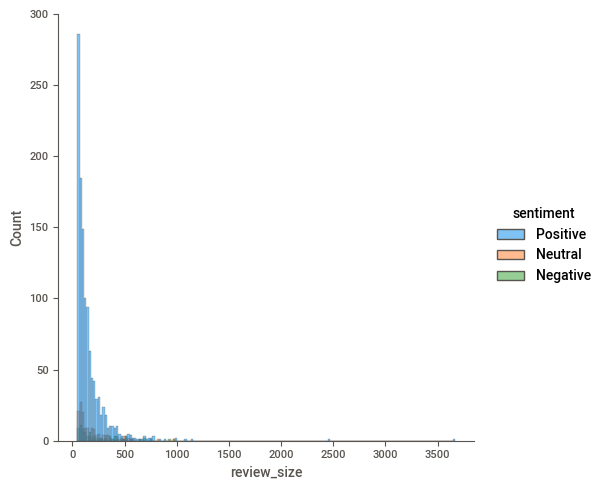

In [23]:
sns.displot(df_train, x='review_size',hue = 'sentiment')

Here we can see that the count of Positive sentiments is more as compared to negative sentimens and also the size of positive sentiment is more compared to others. 

In [24]:
print('Mean review size of Positive review', df_train['review_size'][df_train['sentiment'] == 'Positive'].mean())
print('Mean review size of Positive review', df_train['review_size'][df_train['sentiment'] == 'Neutral'].mean())
print('Mean review size of Positive review', df_train['review_size'][df_train['sentiment'] == 'Negative'].mean())

Mean review size of Positive review 156.46179966044141
Mean review size of Positive review 184.8013698630137
Mean review size of Positive review 246.64102564102564


The average text size is between 155 to 261 characters

## 2. Feature Engineering and Text Cleanup and Converting to Vector format

To make the text compatiable with model we need to remove the stopwords and conver the text into its vectro form.

In [25]:
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'[a-z]+')
stopwords_en = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from bs4 import BeautifulSoup

In [27]:
def preprocess_text(text):
    clean_txt = BeautifulSoup(text, 'lxml').get_text()
    clean_txt = ''.join([c for c in text if c not in string.punctuation])
    clean_txt = clean_txt.lower()
    clean_txt = tokenizer.tokenize(clean_txt)
    clean_txt = ' '.join([stemmer.stem(word) for word in clean_txt if word not in stopwords_en])
    return clean_txt

In [28]:
txt = "Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money"
clean_txt = preprocess_text(txt)
clean_txt

'purchas black fridaypro great price even saleveri power fast quad core processor amaz soundwel builtcon amazon ad amazon need subsid tablet remov add pay inabl access app except one amazon way abl accomplish add googl play storenet great tablet money'

In [29]:
df_train['reviews_clean_text'] = df_train['reviews.text'].apply(preprocess_text)
df_test ['reviews_clean_text'] = df_test['reviews.text'].apply(preprocess_text)
df_test_hidden['reviews_clean_text'] = df_test_hidden['reviews.text'].apply(preprocess_text)

In [30]:
df_test.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,reviews_clean_text
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,amazon kindl fire lot free app use one want ge...
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,echo show great addit amazon famili work like ...
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,great valu best buy bought christma sale
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,use mine email facebook game go line also load...
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,fantast item person bought love


In [31]:
df_train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_size,reviews_clean_text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,"Nice tablet, simple to use",Positive,231,great easi tablet reason price super power get...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-04T00:00:00.000Z,This is my second Kindle and I love it. It's l...,Everything you expect from Amazon,Positive,146,second kindl love lightweight simpl fast conve...
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,81,averag alexa option show thing screen still limit
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,Tablet is perfect for beginners who just want ...,Ease of use,Positive,51,tablet perfect beginn want basic
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,"Great quality, great price and best of all has...",Great deal,Positive,58,great qualiti great price best good sound


In [32]:
df_test_hidden.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_clean_text
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive,amazon kindl fire lot free app use one want ge...
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive,echo show great addit amazon famili work like ...
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive,great valu best buy bought christma sale
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive,use mine email facebook game go line also load...
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive,fantast item person bought love


In [33]:
df_train['reviews_clean_text'][0]

'great easi tablet reason price super power get job done simpl task surf web check email play youtub etc screen clear respons great inexpens tablet'

Since out area of interest is Review text and its corresponding sentiment and our task is to identify the sentiment, lets take the review text and its sentiment only so we can have X as Review and Y as sentiment while training. 

In [34]:
df_train_orig_cleaned = df_train.copy()
df_test_orig_cleaned = df_test.copy()
df_test_hidden_cleaned = df_test_hidden.copy()

In [35]:
df_train_orig_cleaned.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,review_size,reviews_clean_text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,"Nice tablet, simple to use",Positive,231,great easi tablet reason price super power get...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-04T00:00:00.000Z,This is my second Kindle and I love it. It's l...,Everything you expect from Amazon,Positive,146,second kindl love lightweight simpl fast conve...
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,81,averag alexa option show thing screen still limit
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,Tablet is perfect for beginners who just want ...,Ease of use,Positive,51,tablet perfect beginn want basic
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,"Great quality, great price and best of all has...",Great deal,Positive,58,great qualiti great price best good sound


Removing unnecessary columns to keep only the cleaned text and sentiments

In [36]:
df_train = df_train[['reviews_clean_text', 'sentiment']]
df_test_hidden = df_test_hidden[['reviews_clean_text','sentiment']]
df_test = df_test['reviews_clean_text']

Using the Training data set to firther split into Train adn Test test.

In [37]:
df_train.head()

,reviews_clean_text,sentiment
0,great easi tablet reason price super power get...,Positive
1,second kindl love lightweight simpl fast conve...,Positive
2,averag alexa option show thing screen still limit,Neutral
3,tablet perfect beginn want basic,Positive
4,great qualiti great price best good sound,Positive


In [38]:
df_test.head()

0    amazon kindl fire lot free app use one want ge...
1    echo show great addit amazon famili work like ...
2             great valu best buy bought christma sale
3    use mine email facebook game go line also load...
4                      fantast item person bought love
Name: reviews_clean_text, dtype: object

Splitting the Training data into train and test split

In [39]:
X = df_train['reviews_clean_text']
y = df_train['sentiment']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101,stratify=y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1121,)
(1121,)
(281,)
(281,)


### 2. Convert the reviews in Tf-Idf score.

In [41]:
# tfidf_vec = TfidfVectorizer(max_features = 3500, max_df = 10, min_df= 3, ngram_range=(1,2))
tfidf_vec = TfidfVectorizer(max_features = 5000, max_df = 10, min_df= 3, ngram_range=(1,2))

In [42]:
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec = tfidf_vec.transform(x_test)

In [43]:
print(x_train_vec.shape)
print(x_test_vec.shape)
print(y_train.shape)
print(y_test.shape)

(1121, 1092)
(281, 1092)
(1121,)
(281,)


### 5. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.


To check model performance we can use all the classification metrics like accuracy score, precision/recall/f1 score for individual and overall classes as part of classification report. ROC_AUC also can be calculated and AUC curve can be shown for each class label. 

It would be helpful to compare the performance between different models as well as different datasets (train, test, etc.)

We can mainly focus on F1-score here as accuracy is not good choice for imbalance data.


In [44]:
def getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, name):
    print("Accuracy score Train", accuracy_score(y_train, y_pred_train))
    print("Accuracy score Test", accuracy_score(y_test, y_pred_test))
    
    print("\nTrain Classification Report: " + name + "\n")
    print(classification_report(y_train, y_pred_train))
    print("\nTest Classification Report: " + name + "\n")
    print(classification_report(y_test, y_pred_test))
    
    print("\nTrain Confusion matrix: " + name + "\n")
    print(pd.DataFrame(confusion_matrix(y_train, y_pred_train), columns= classes, index = classes))
    
    print("\nTest Confusion matrix: " + name + "\n")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns= classes, index = classes))
    
    train_op = OneVsRest(y_train, y_pred_train)
    test_op = OneVsRest(y_test, y_pred_test)
    
    for c, y_y_pred in zip(classes, train_op):
        print("\nROC AUC score train class {}: {}".format(c, roc_auc_score(y_y_pred[0], y_y_pred[1])))
        
    for c, y_y_pred in zip(classes, train_op):
        fpr, tpr, th = roc_curve(y_y_pred[0], y_y_pred[1])
        auc_val = auc(fpr, tpr)
        plt.title(name + 'Train Receiver Operating Characteristics: ' + c + 'class')
        plt.plot(fpr, tpr , label = 'area = {:.3f}'.format(auc_val))
        plt.legend(loc = 'lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.ylabel("True Positice Rate")
        plt.xlabel("Flase Positive Rate")
        plt.show()
    
    for c, y_y_pred in zip(classes, train_op):
        print('\nRoc AUC score test class {}: {}'.format(c, roc_auc_score(y_y_pred[0], y_y_pred[1])))
    
    for c, y_y_pred in zip(classes, test_op):
        fpr, tpr, th = roc_curve(y_y_pred[0], y_y_pred[1])
        auc_val = auc(fpr, tpr)
        plt.title(name + 'Test Receiver Operating Characteristics ' + c + 'class')
        plt.plot(fpr, tpr, label = 'area {:.3f}'.format(auc_val))
        plt.legend(loc = 'lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.ylabel("True Positice Rate")
        plt.xlabel("Flase Positive Rate")
        plt.show()

In [45]:
def OneVsRest(y, y_pred):
    outputs = []
    for c in classes:
        y_one = list(map(lambda x: 1 if x == c else 0, y))
        y_one_red = list(map(lambda x: 1 if x == c else 0, y_pred))
        outputs.append((y_one, y_one_red))
    return outputs

### 3. Run multinomial Naive Bayes Classifier. Everything will be classified as positive because of class imbalance.

Multinomial Naive Bayes Classifier works as per naive bayes rule considering the prior probabilities. It is a best choice for textual Data.

We can train the model and get the sentiment prediction for both train test data and get model performance using predicted and actual sentiments.

These steps can be followed for all the model going forward. 

In [46]:
mul_nb_model = MultinomialNB()
mul_nb_model.fit(x_train_vec, y_train)
y_pred_train = mul_nb_model.predict(x_train_vec)
y_pred_test = mul_nb_model.predict(x_test_vec)

In [47]:
classes = mul_nb_model.classes_
print(classes)

['Negative' 'Neutral' 'Positive']


Accuracy score Train 0.8438893844781445
Accuracy score Test 0.8398576512455516

Train Classification Report: Naive Bayes on unbalanced dataset

              precision    recall  f1-score   support

    Negative       1.00      0.02      0.03        62
     Neutral       1.00      0.03      0.05       117
    Positive       0.84      1.00      0.92       942

    accuracy                           0.84      1121
   macro avg       0.95      0.35      0.33      1121
weighted avg       0.87      0.84      0.78      1121


Test Classification Report: Naive Bayes on unbalanced dataset

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        16
     Neutral       0.00      0.00      0.00        29
    Positive       0.84      1.00      0.91       236

    accuracy                           0.84       281
   macro avg       0.28      0.33      0.30       281
weighted avg       0.71      0.84      0.77       281


Train Confusion matrix: Naive

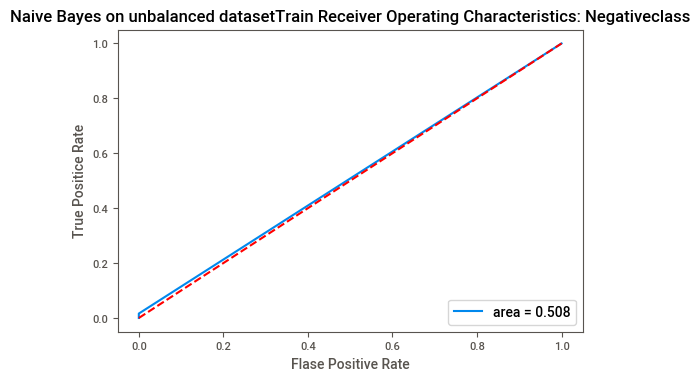

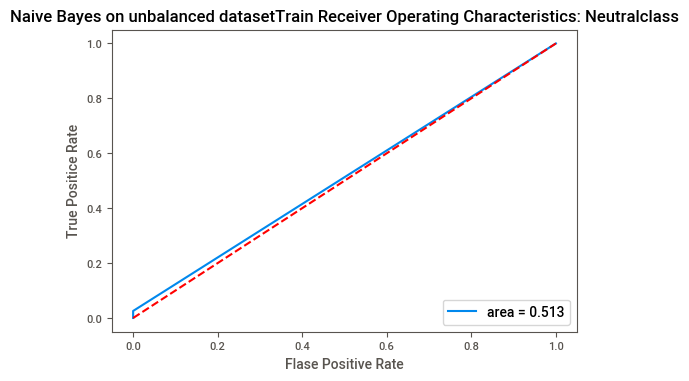

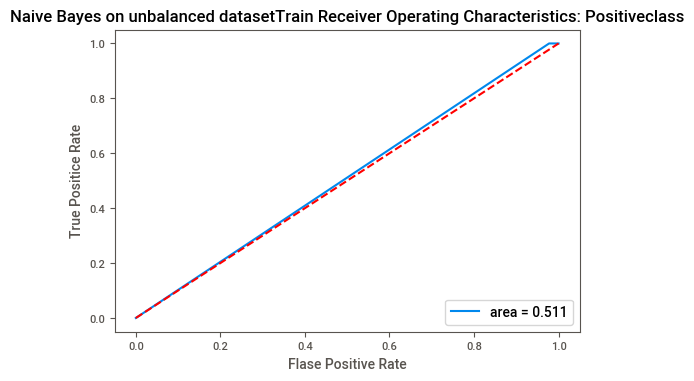


Roc AUC score test class Negative: 0.5080645161290323

Roc AUC score test class Neutral: 0.5128205128205128

Roc AUC score test class Positive: 0.5111731843575419


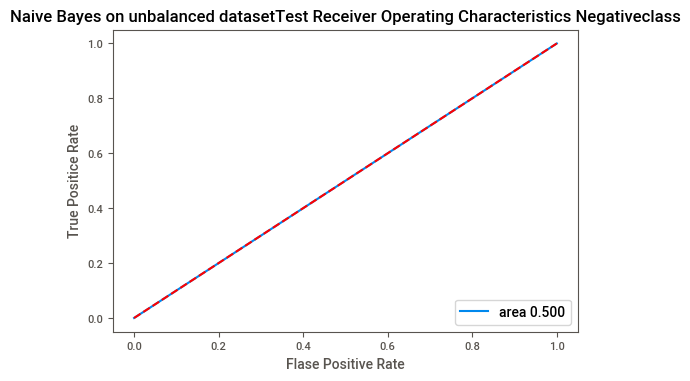

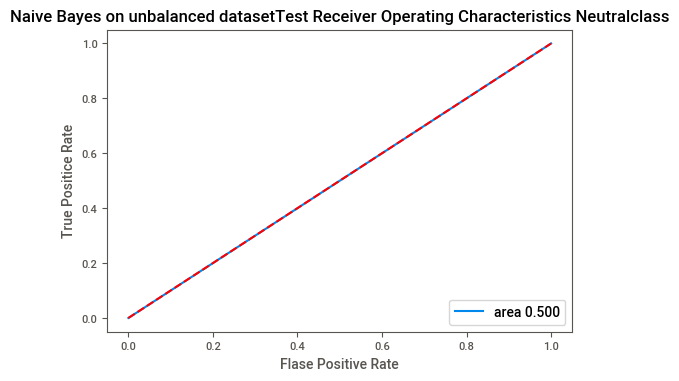

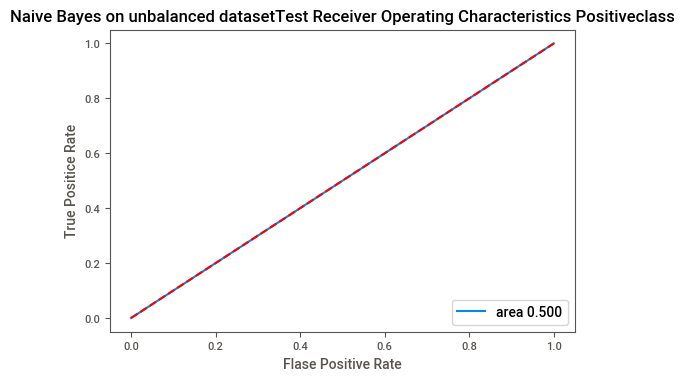

In [48]:
# Performance of Naive Bayes on Unbalanced dataset
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'Naive Bayes on unbalanced dataset')

Now lets test for Test data

In [49]:
df_test_hidden.head()

,reviews_clean_text,sentiment
0,amazon kindl fire lot free app use one want ge...,Positive
1,echo show great addit amazon famili work like ...,Positive
2,great valu best buy bought christma sale,Positive
3,use mine email facebook game go line also load...,Positive
4,fantast item person bought love,Positive


In [50]:
x_test_hidden_vector = tfidf_vec.transform(df_test_hidden['reviews_clean_text'])
y_test_hidden = df_test_hidden['sentiment']

In [51]:
print(x_test_hidden_vector.shape)

(1000, 1092)


In [52]:
y_test_hidden_predict = mul_nb_model.predict(x_test_hidden_vector)

In [53]:
print('Test_hidden accuracy score {} \n'. format(accuracy_score(y_test_hidden, y_test_hidden_predict)))
print('Classification report \n')
print(classification_report(y_test_hidden, y_test_hidden_predict))

Test_hidden accuracy score 0.939 

Classification report 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       1.00      0.05      0.10        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.65      0.35      0.36      1000
weighted avg       0.92      0.94      0.91      1000



In [54]:
# Function to transform the Train, Test or whole dataset of review comments into tfidf vectorizer.
def test_transform(x_train, x_test):
    if x_train is not None:
        x_train_vec = tfidf_vec.fit_transform(x_train)
    if x_test is None:
        return x_train_vec
    x_test_vec = tfidf_vec.transform(x_test)
    
    return x_test_vec if x_train is None else (x_train_vec, x_test)

Saving the MNB on unbalanced data model

In [55]:
pickle.dump(mul_nb_model, open('mnb_unbalanced.pkl', 'wb'))

As we see that by using imbalance data we get most of the results as positive. This means that the reviews have been assigned 'Positive SeNtiments' even if they are not. 

## B. Tackling Class Imbalance Problem:

### 4. Oversampling or undersampling can be used to tackle the class imbalance problem.

To tackle the class imbalance problem we will use Over Sampling instead of under sampling as Under sampling is removing the data from the large percentage of the data which will lead to loss of information. 

For this I am using the Contestual Word Augumenter with bert model. This will help me to create similar sentence for a given sentence. 

We can also use SMOTE.

In [225]:
# !pip3 install transformers

In [56]:
import nlpaug.augmenter.word.context_word_embs as aug
augumenter = aug.ContextualWordEmbsAug(model_path= 'bert-base-uncased', action = 'insert')

In [57]:
sample_text_negative = df_train_orig_cleaned[df_train_orig_cleaned['sentiment'] == 'Negative']
sample_text = sample_text_negative['reviews.text'].iloc[10]
sample_text

'My first tablet was a Kindle. I was curious about the updated version. Very disappointed'

In [58]:
augumented_sample_text = augumenter.augment(sample_text)
print(augumented_sample_text)
print(augumented_sample_text[0])

['my great first tablet interface was a kindle. i probably was curious initially about receiving the updated version. and very disappointed']
my great first tablet interface was a kindle. i probably was curious initially about receiving the updated version. and very disappointed


In [59]:
def augmentMyData(df, augmenter, minority_label, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    review_df = df[df['sentiment'] == minority_label].reset_index(drop=True) # removes unecessary index column
    
    for i in tqdm(np.random.randint(0, len(review_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(review_df['reviews.text'].iloc[i])
            augmented_texts.append(augmented_text[0])            
    
    data = {
        'sentiment': minority_label,
        'reviews.text': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

Sample testing of how bert data augmenter works

In [60]:
df_test = df_train_orig_cleaned.loc[[0,6,10,12,33,100]][['reviews.text', 'sentiment']]
df_test

,reviews.text,sentiment
0,Great easy tablet for a reasonable price. Not ...,Positive
6,"was cheap, can not run chrome stuff, returned ...",Negative
10,This is my 3rd Kindle upgrade. I love everythi...,Positive
12,"If you love Amazon, you'll love the Kindle HD8...",Positive
33,This was my second kindle and I didn't realize...,Neutral
100,I enjoy the premium sound with this Amazon Ech...,Positive


In [61]:
df_test_augumnet = augmentMyData(df_test, augumenter, 'Positive', samples=5)
df_test_augumnet

  0%|          | 0/5 [00:00<?, ?it/s]

,reviews.text,sentiment
9,i enjoy combining the premium sound with havin...,Positive
2,This is my 3rd Kindle upgrade. I love everythi...,Positive
3,"If you love Amazon, you'll love the Kindle HD8...",Positive
1,"was cheap, can not run chrome stuff, returned ...",Negative
6,this is my 3rd annual kindle upgrade. today i ...,Positive
7,i really enjoy the ultra premium sound with th...,Positive
8,i especially enjoy the extra premium sound wit...,Positive
4,This was my second kindle and I didn't realize...,Neutral
5,I enjoy the premium sound with this Amazon Ech...,Positive
0,Great easy tablet for a reasonable price. Not ...,Positive


In [62]:
df_test_augumnet = augmentMyData(df_test, augumenter, 'Neutral', samples=5)
df_test_augumnet

  0%|          | 0/5 [00:00<?, ?it/s]

,reviews.text,sentiment
2,This is my 3rd Kindle upgrade. I love everythi...,Positive
4,This was my second kindle and I didn't realize...,Neutral
10,actually this was my old second favourite kind...,Neutral
6,this was my usual second school kindle and i d...,Neutral
1,"was cheap, can not run chrome stuff, returned ...",Negative
0,Great easy tablet for a reasonable price. Not ...,Positive
8,this was my second favorite kindle and i didn'...,Neutral
9,yes this was my second kindle and i actually d...,Neutral
3,"If you love Amazon, you'll love the Kindle HD8...",Positive
7,now this was my favorite second kindle and i d...,Neutral


* Here we will first create the new dataset from the origrinal dataset taking only the reviews and sentiments and then oversample it for Neutral and Negative sentiments so we can get a balanced dataset.

* Once we have the balanced dataset of reviews, we will clean the augmented balanced dataset and create a new columns of cleanet reveiws.

* Then we will remove the review.title column from the dataset to have just two columns cleaned review and sentiments.

* Create X and y from dataframe

* Apply tf-idf vectorizer on X.

* Split X vectors and y labes using traintestsplit

* Using this vectors apply it on Multinomial Naive Bayes and XGboost



In [63]:
df_train_new = df_train_orig_cleaned[['reviews.text','sentiment']]
df_train_new.head()

,reviews.text,sentiment
0,Great easy tablet for a reasonable price. Not ...,Positive
1,This is my second Kindle and I love it. It's l...,Positive
2,Just an average Alexa option. Does show a few ...,Neutral
3,Tablet is perfect for beginners who just want ...,Positive
4,"Great quality, great price and best of all has...",Positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

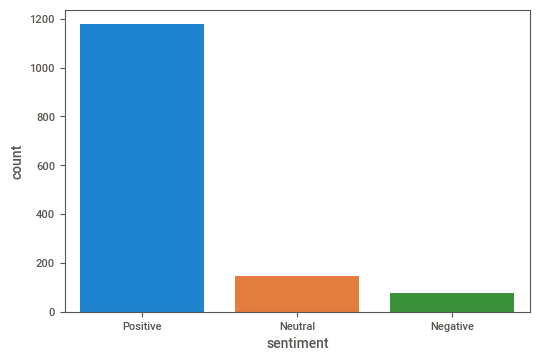

In [64]:
sns.countplot(df_train_new['sentiment'])

In [65]:
# Augment 'Neutral' comments to create 3500 more similar samples.
df_train_aug = augmentMyData(df_train_new, augumenter, 'Neutral', samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='sentiment', ylabel='count'>

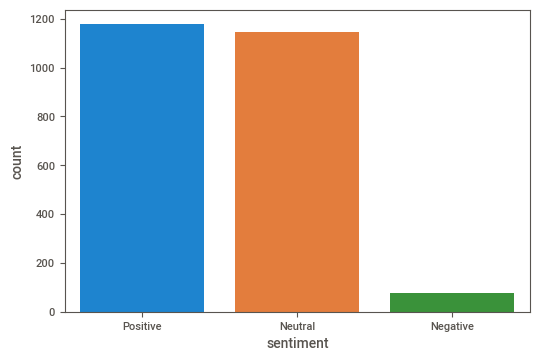

In [66]:
sns.countplot(df_train_aug['sentiment'])

In [67]:
# Augment 'Negative' comments to create 3500 more similar samples.
df_train_aug_new = augmentMyData(df_train_aug, augumenter, 'Negative', samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='sentiment', ylabel='count'>

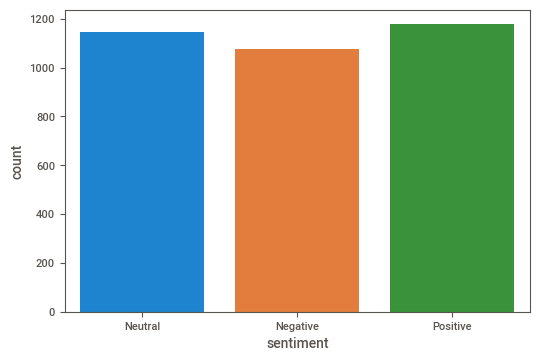

In [68]:
sns.countplot(df_train_aug_new['sentiment'])

##### This df_train_aug_new is a Balanced dataset with uncleaned reviews.

In [69]:
df_train_aug_new.isnull().sum()

reviews.text    0
sentiment       0
dtype: int64

In [70]:
print('After Balancing, train Positive', sum(df_train_aug_new['sentiment'] == 'Positive'))
print('After Balancing, train Negative', sum(df_train_aug_new['sentiment'] == 'Negative'))
print('After Balancing, train Neutral', sum(df_train_aug_new['sentiment'] == 'Neutral'))

After Balancing, train Positive 1178
After Balancing, train Negative 1078
After Balancing, train Neutral 1146


Cleaning the Reviews

In [71]:
df_train_aug_new['reviews_clean_text'] = df_train_aug_new['reviews.text'].apply(preprocess_text)

In [72]:
df_train_aug_new.head()

,reviews.text,sentiment,reviews_clean_text
2021,this was my own second kindle and today i almo...,Neutral,second kindl today almost didnt realiz wasnd p...
479,I'm disappointed that it doesn't have a mirror...,Neutral,im disappoint doesnt mirror display mode
3174,less than useless does not work with amazon cl...,Negative,less useless work amazon cloudcam purchas best...
1761,it's an unfair country for of me to rate this ...,Neutral,unfair countri rate littl product caus even ta...
2246,"for me, the kindle black was not a good fit ei...",Neutral,kindl black good fit either actual time read l...


Creating X - reviews and y- labels

In [73]:
X = df_train_aug_new['reviews_clean_text']
y= df_train_aug_new['sentiment']

In [74]:
print(X.count())
print(y.count())

3402
3402


In [75]:
y.shape

(3402,)

In [76]:
x_train_txt, x_test_txt, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify= y, random_state=101)

In [77]:
print(x_train_txt.shape)
print(y_train.shape)
print(x_test_txt.shape)
print(y_test.shape)

(2381,)
(2381,)
(1021,)
(1021,)


In [78]:
x_train_txt_vec = tfidf_vec.fit_transform(x_train_txt)
x_test_txt_vec = tfidf_vec.transform(x_test_txt)
print(x_train_txt_vec.shape)
print(x_test_txt_vec.shape)
print(y_train.shape)
print(y_test.shape)

(2381, 3724)
(1021, 3724)
(2381,)
(1021,)


### Using Multinomial Naive Bayes on Balanced dataset

In [79]:
mul_nb_model_bal = MultinomialNB()

Hyperparameter Tuning

In [80]:
param = {'alpha': [0.001, 0.005, 0.1, 0.5, 1]}
gridsearch_nb = GridSearchCV(mul_nb_model_bal, param, refit=True, scoring = make_scorer(f1_score, average = 'macro'))

In [81]:
gridsearch_nb.fit(x_train_txt_vec,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.005, 0.1, 0.5, 1]},
             scoring=make_scorer(f1_score, average=macro))

In [82]:
y_train_txt_pred = gridsearch_nb.predict(x_train_txt_vec)
y_test_txt_pred = gridsearch_nb.predict(x_test_txt_vec)

In [83]:
classes = gridsearch_nb.classes_
classes

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [84]:
gridsearch_nb.best_score_

0.9142783441174751

In [85]:
gridsearch_nb.best_params_

{'alpha': 0.1}

In [86]:
mnb_model = gridsearch_nb.best_estimator_
mnb_model

MultinomialNB(alpha=0.1)

### 5. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

Multinomial Naive Bayes on Balanced dataset
Accuracy score Train 0.9773204535909282
Accuracy score Test 0.9187071498530852

Train Classification Report: Naive Bayes Balanced

              precision    recall  f1-score   support

    Negative       1.00      0.95      0.97       755
     Neutral       0.99      0.99      0.99       802
    Positive       0.95      0.99      0.97       824

    accuracy                           0.98      2381
   macro avg       0.98      0.98      0.98      2381
weighted avg       0.98      0.98      0.98      2381


Test Classification Report: Naive Bayes Balanced

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95       323
     Neutral       0.91      0.93      0.92       344
    Positive       0.89      0.88      0.89       354

    accuracy                           0.92      1021
   macro avg       0.92      0.92      0.92      1021
weighted avg       0.92      0.92      0.92      1021


Train Confu

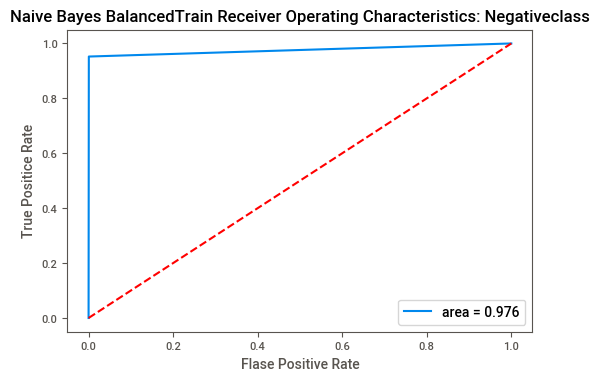

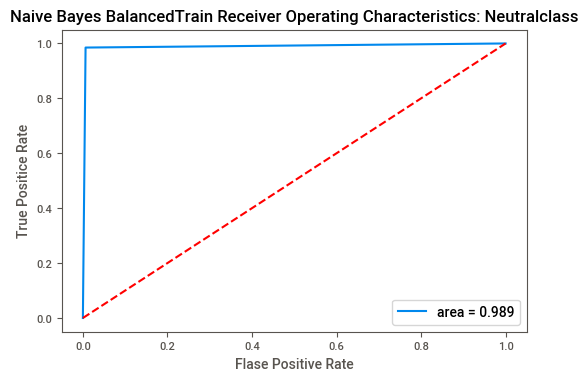

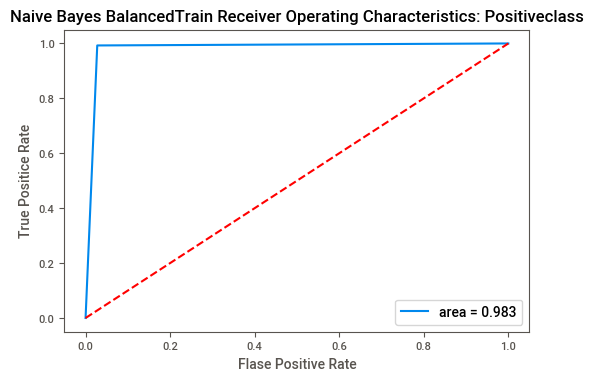


Roc AUC score test class Negative: 0.9758514373223203

Roc AUC score test class Neutral: 0.9893521421272657

Roc AUC score test class Positive: 0.9825506170068155


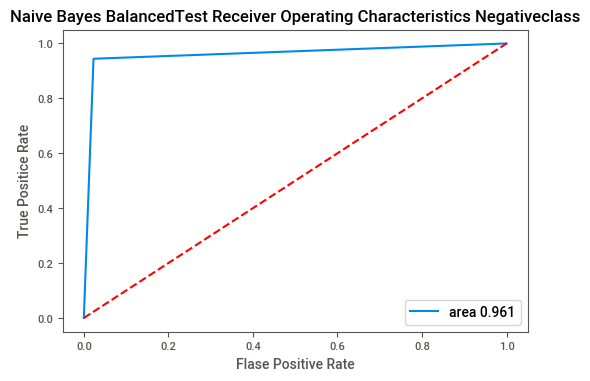

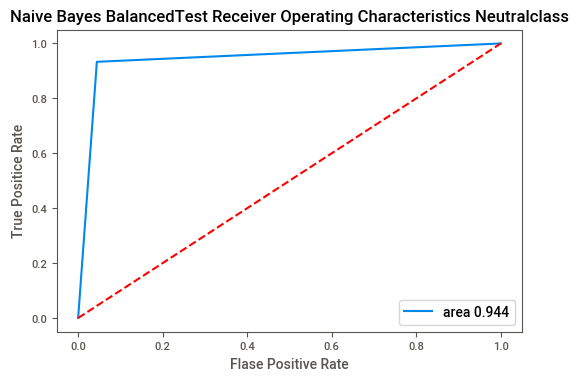

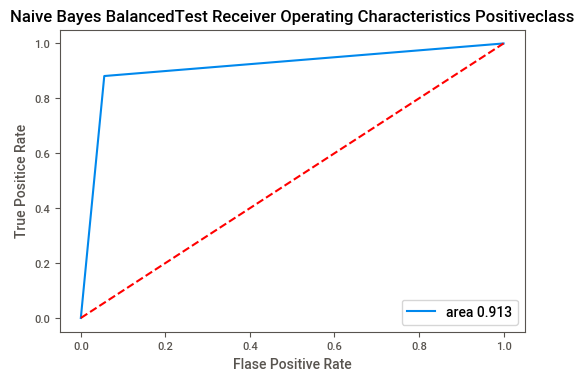

In [87]:
print("Multinomial Naive Bayes on Balanced dataset")
getPerformance(y_train, y_train_txt_pred, y_test, y_test_txt_pred, classes, 'Naive Bayes Balanced')

The above results are on the Trianing and Test data.

Now lets check our model perfromance on the hidden data.

In [88]:
x_test_hidden_vec = test_transform(None, df_test_hidden['reviews_clean_text'])
y_test_hidden = df_test_hidden['sentiment']
print(x_test_hidden_vec.shape)
print(y_test_hidden.shape)

(1000, 3724)
(1000,)


In [89]:
y_test_hidden_predicted_MNB = mnb_model.predict(x_test_hidden_vec)
print('Multinomial Naive Bayes on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_MNB)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_MNB))

Multinomial Naive Bayes on Hidden data 

Hidden data Test Accuracy score 0.83 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.17      0.46      0.25        24
     Neutral       0.14      0.36      0.20        39
    Positive       0.96      0.86      0.91       937

    accuracy                           0.83      1000
   macro avg       0.43      0.56      0.45      1000
weighted avg       0.91      0.83      0.86      1000



##### As we can see above the f1-score macro is 0.49 which is better than that of the unbalanced data set (0.39). 

Saving the Model

In [90]:
pickle.dump(mnb_model, open('mnb_model_trained_with_balanced_data.pkl','wb'))

In [91]:
df_test_hidden_ecom = pd.DataFrame.sparse.from_spmatrix(x_test_hidden_vec)

In [92]:
df_test_hidden_ecom.head()

,0,1,2,3,4,5,6,7,8,9,...,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
df_test_hidden_ecom = pd.concat([df_test_hidden_ecom, y_test_hidden], axis = 1)

In [94]:
df_test_hidden_ecom.head()

,0,1,2,3,4,5,6,7,8,9,...,3715,3716,3717,3718,3719,3720,3721,3722,3723,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


In [95]:
df_test_hidden_ecom.to_pickle('df_test_hidden_ecom.pkl')

From all the above metrices, we can see that the model performance has improved after balancing the data. Now the scores are no longer less for data with Negative and Neutral sentiments in Training and Test results

### 6. Use Tree-based classifiers like Random Forest and XGBoost.

We can go for ensamble models that can enhance the model performace as they use multiple based models with bagging boosting techniques.

So we can try out RandomForest and XGBoost which uses Tree based models (Decision Tree) as their base model.

We can compare their performance and finally choose the best ML model.

#### 6.1 Random Forest with balanced dataset

In [96]:
rf = RandomForestClassifier(class_weight= 'balanced')
params = {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 15], 'min_samples_split':[2, 4, 6]}
gs_rf = GridSearchCV(rf, params, refit = True, scoring= make_scorer(f1_score, average = 'macro'))
gs_rf.fit(x_train_txt_vec, y_train)
y_pred_train_txt_rf = gs_rf.predict(x_train_txt_vec)
y_pred_test_txt_rf = gs_rf.predict(x_test_txt_vec)

In [97]:
classes = gs_rf.classes_
print(classes)
print('Random Forest Best Score with balance dataset',gs_rf.best_score_)
print('Random Forest Best Params with balance dataset', gs_rf.best_params_)

['Negative' 'Neutral' 'Positive']
Random Forest Best Score with balance dataset 0.5442693091086804
Random Forest Best Params with balance dataset {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}


In [98]:
gridSearch_randomForest_model = gs_rf.best_estimator_
gridSearch_randomForest_model

RandomForestClassifier(class_weight='balanced', max_depth=15)

Performance - Random Forest with balanced dataset
Accuracy score Train 0.6976060478790425
Accuracy score Test 0.6327130264446621

Train Classification Report: Random Forest with balanced dataset

              precision    recall  f1-score   support

    Negative       1.00      0.59      0.74       755
     Neutral       0.99      0.50      0.66       802
    Positive       0.53      1.00      0.70       824

    accuracy                           0.70      2381
   macro avg       0.84      0.69      0.70      2381
weighted avg       0.83      0.70      0.70      2381


Test Classification Report: Random Forest with balanced dataset

              precision    recall  f1-score   support

    Negative       0.98      0.56      0.71       323
     Neutral       0.91      0.37      0.52       344
    Positive       0.49      0.96      0.64       354

    accuracy                           0.63      1021
   macro avg       0.79      0.63      0.63      1021
weighted avg       0.79      0.

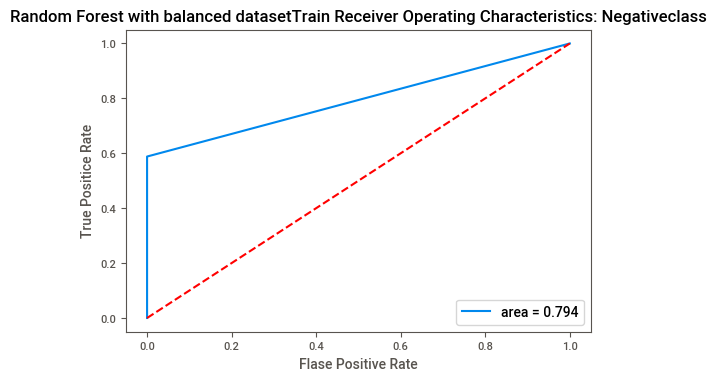

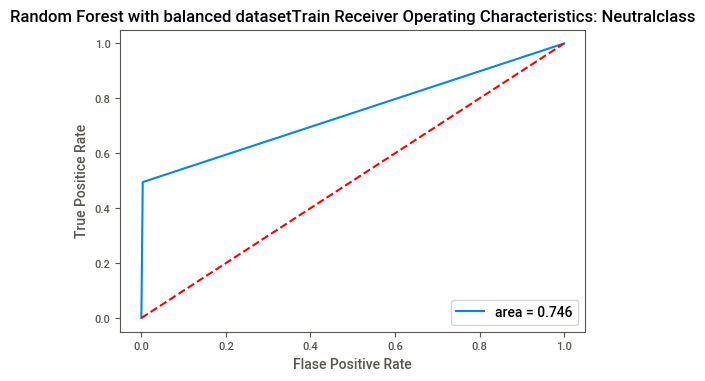

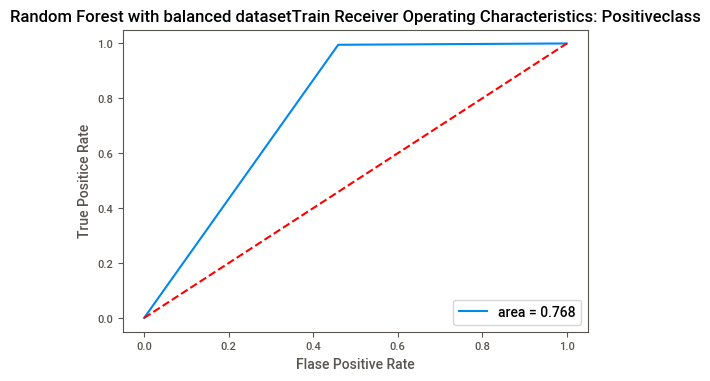


Roc AUC score test class Negative: 0.7940397350993378

Roc AUC score test class Neutral: 0.7459229538566504

Roc AUC score test class Positive: 0.7679645945962799


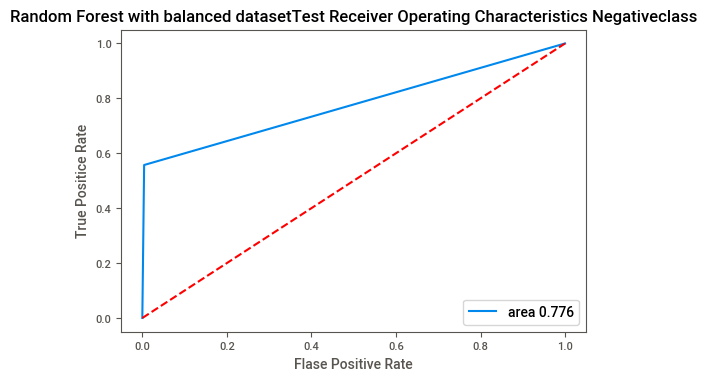

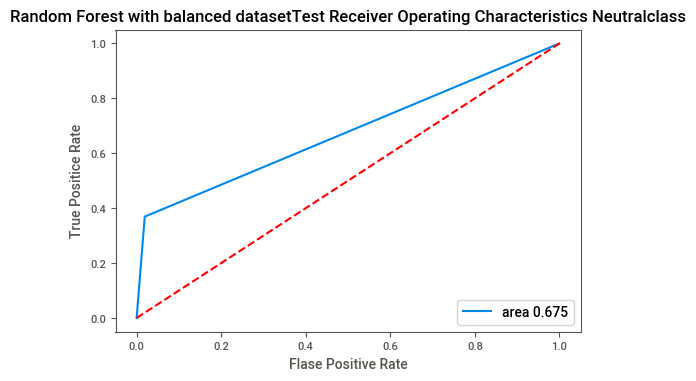

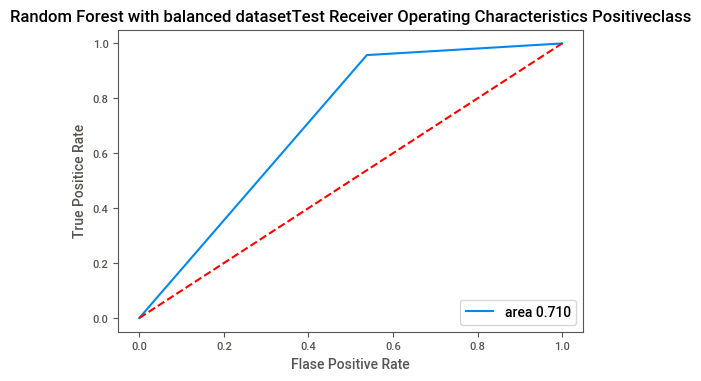

In [99]:
print('Performance - Random Forest with balanced dataset')
getPerformance(y_train, y_pred_train_txt_rf, y_test, y_pred_test_txt_rf, classes, 'Random Forest with balanced dataset')

#### Now testing Random forest on hidden dataset

In [100]:
y_test_hidden_predicted_rf = gs_rf.predict(x_test_hidden_vec)
print('Random Forest on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_rf)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_rf))

Random Forest on Hidden data 

Hidden data Test Accuracy score 0.906 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.33      0.17      0.22        24
     Neutral       0.15      0.15      0.15        39
    Positive       0.94      0.96      0.95       937

    accuracy                           0.91      1000
   macro avg       0.48      0.43      0.44      1000
weighted avg       0.90      0.91      0.90      1000



#### 6.2  XGboost classifier 
For XGB classifier we need to convert the text labels to numeric as I am runnig it on local Jupyter Nootbook with a version of XGB that dose not support text labels. So I am using Label Encoder to encode the y_train and y_test labels 

0 - Negative

1 - Neutral

2 - Positive

In [101]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_lb_enc = le.fit_transform(y_train)
y_train_lb_enc

array([0, 2, 0, ..., 0, 1, 1])

In [102]:
xgb = XGBClassifier(objective = 'multi:softmax')
params = {
    "gamma": [0.001, 0.01, 0.1],
    "max_depth": [3,6,9],
    "n_estimators": [50, 100, 150] 
    }
gs_xgbc = GridSearchCV(xgb, params, refit=True, scoring= make_scorer(f1_score, average = 'macro'))
gs_xgbc.fit(x_train_txt_vec,y_train_lb_enc)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'gamma': [0.001, 0.01, 0.1], 'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(f1_score, average=macro))

In [103]:
y_pred_train_xgb = gs_xgbc.predict(x_train_txt_vec)
y_pred_test_xgb = gs_xgbc.predict(x_test_txt_vec)

In [104]:
classes_xgb = gs_xgbc.classes_
print(classes_xgb)
print(y_train_lb_enc)

[0 1 2]
[0 2 0 ... 0 1 1]


In [105]:
y_train

2770    Negative
884     Positive
2565    Negative
2811    Negative
933      Neutral
          ...   
972     Positive
3145    Negative
3245    Negative
131      Neutral
587      Neutral
Name: sentiment, Length: 2381, dtype: object

From above comparision it is crear that the the labels are encoded in following ways

0 - Negative,
1 - Neutral,
2 - Positive

In [106]:
print('XGB Best Score with balance data ', gs_xgbc.best_score_)
print('XGB Best Params with balance data', gs_xgbc.best_params_ )

XGB Best Score with balance data  0.848318954515934
XGB Best Params with balance data {'gamma': 0.1, 'max_depth': 9, 'n_estimators': 150}


In [107]:
# XGB Best Estimator
gridSearch_xgb_model = gs_xgbc.best_estimator_
gridSearch_xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

In [108]:
y_test_lb_enc = le.fit_transform(y_test)

In [109]:
# Function to convert the encoded labels of back to text values.
def decodeLabels(label_array):
    decoded_label = []
    for lbl in label_array:
        if lbl == 0:
            decoded_label.append('Negative')
        elif lbl == 1:
            decoded_label.append('Neutral')
        else:
            decoded_label.append('Positive')
    
    decoded_label_array = np.array(decoded_label)
    return decoded_label_array

In [110]:
y_pred_decoded_train_xgb = decodeLabels(y_pred_train_xgb)
y_pred_decoded_test_xgb = decodeLabels(y_pred_test_xgb)
print(y_pred_decoded_train_xgb)
print(y_pred_decoded_test_xgb)

['Negative' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Neutral']
['Positive' 'Neutral' 'Negative' ... 'Positive' 'Positive' 'Neutral']


Accuracy score Train 0.9655606887862243
Accuracy score Test 0.8687561214495593

Train Classification Report: XGboost

              precision    recall  f1-score   support

    Negative       1.00      0.92      0.96       755
     Neutral       0.99      0.98      0.98       802
    Positive       0.92      1.00      0.96       824

    accuracy                           0.97      2381
   macro avg       0.97      0.96      0.97      2381
weighted avg       0.97      0.97      0.97      2381


Test Classification Report: XGboost

              precision    recall  f1-score   support

    Negative       0.97      0.88      0.92       323
     Neutral       0.91      0.83      0.86       344
    Positive       0.77      0.90      0.83       354

    accuracy                           0.87      1021
   macro avg       0.88      0.87      0.87      1021
weighted avg       0.88      0.87      0.87      1021


Train Confusion matrix: XGboost

          Negative  Neutral  Positive
Negative  

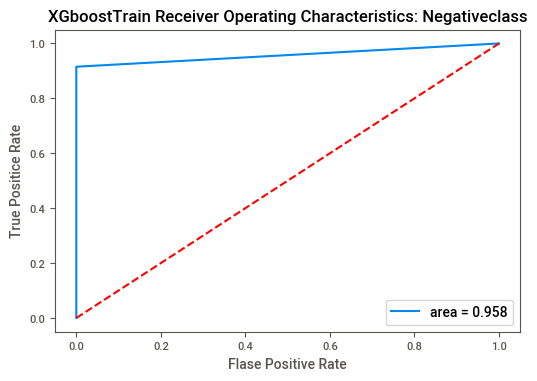

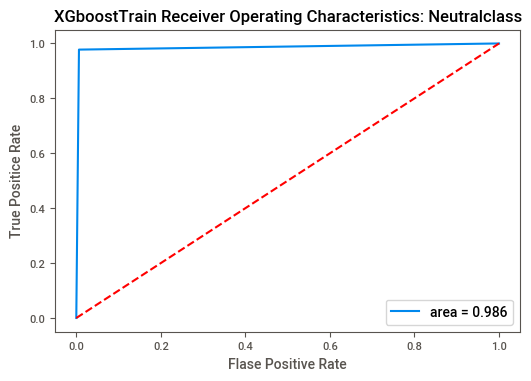

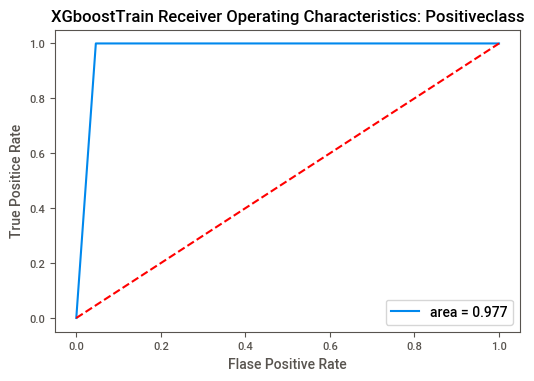


Roc AUC score test class Negative: 0.957615894039735

Roc AUC score test class Neutral: 0.9856114937482133

Roc AUC score test class Positive: 0.976878612716763


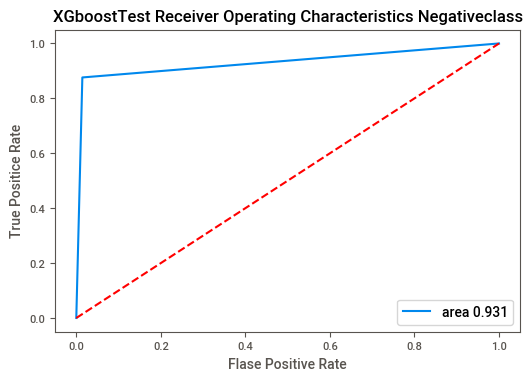

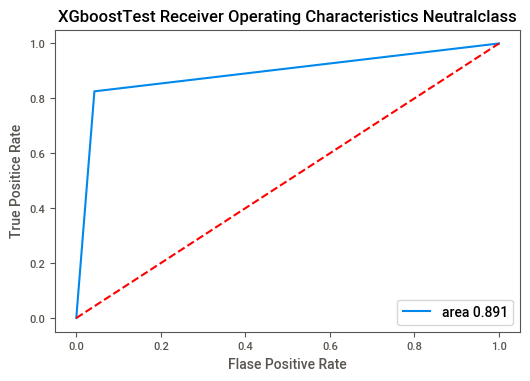

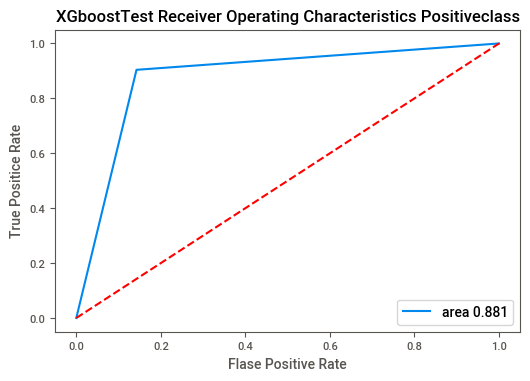

In [111]:
getPerformance(y_train, y_pred_decoded_train_xgb, y_test, y_pred_decoded_test_xgb, classes, 'XGboost')

#### Testing XGboost model on hidden data

In [112]:
y_test_hidden_predicted_xgb = gs_xgbc.predict(x_test_hidden_vec)
y_test_hidden_predicted_decoded_xgb = decodeLabels(y_test_hidden_predicted_xgb)

In [113]:
print('XGboost on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_decoded_xgb)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_decoded_xgb))

XGboost on Hidden data 

Hidden data Test Accuracy score 0.9 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.35      0.33      0.34        24
     Neutral       0.22      0.31      0.26        39
    Positive       0.95      0.94      0.95       937

    accuracy                           0.90      1000
   macro avg       0.51      0.53      0.51      1000
weighted avg       0.91      0.90      0.90      1000



In [114]:
pickle.dump(gridSearch_xgb_model,open('xgb_trained_balanced.pkl', 'wb'))

### Comparing Hidden test Results of Multinomial Naive Bayes, Random Forest and XGBoost on Balanced data

##### Multinomial Naive Bayes classifier trained on balanced data and tested on hidden data 

Hidden data Test Accuracy score 0.853 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.21      0.54      0.31        24
     Neutral       0.18      0.41      0.25        39
    Positive       0.97      0.88      0.92       937

    accuracy                           0.85      1000
    macro avg      0.45      0.61      0.49      1000
    weighted avg   0.92      0.85      0.88      1000



##### Grid Search Random Forest Classifier trained on balanced data and tested on hidden data 

Hidden data Test Accuracy score 0.903 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.57      0.17      0.26        24
     Neutral       0.14      0.18      0.16        39
    Positive       0.94      0.95      0.95       937

    accuracy                           0.90      1000
    macro avg      0.55      0.43      0.46      1000
    weighted avg   0.90      0.90      0.90      1000



##### XGBoost Classifier on hidden data

XGboost on Hidden data 

Hidden data Test Accuracy score 0.913 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.64      0.29      0.40        24
     Neutral       0.24      0.33      0.28        39
    Positive       0.96      0.95      0.95       937

    accuracy                           0.91      1000
    macro avg      0.61      0.53      0.54      1000
    weighted avg   0.92      0.91      0.91      1000

### From the above comparision it is clear that XGboost classifier has given better result than Multinomial Naive Bayes and Random Forest. The f1-score of XGboost for all three reviews are better than other thow classifiers.  

### Saving tfidf vectorizer and balanced data for future use.

In [115]:
df_ecomm_train = pd.DataFrame.sparse.from_spmatrix(x_train_txt_vec)
df_ecomm_train = pd.concat([df_ecomm_train,y], axis = 1)
df_ecomm_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3715,3716,3717,3718,3719,3720,3721,3722,3723,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


In [116]:
# saving the tfidf vectorizer dataset
df_ecomm_train.to_pickle('df_ecom_train_sparse.pkl')
pickle.dump(tfidf_vec, open('tfidf.pkl','wb'))

## Topic Modeling
### Getting top 10 features in XGboost

We can get the weights representing importance of the features used in XGboost

In [117]:
feature_names = np.array(tfidf_vec.get_feature_names())
feature_names

array(['abil', 'abl camera', 'abl clear', ..., 'youtub wont',
       'youtub youll', 'zinio'], dtype='<U21')

In [118]:
importances = gridSearch_xgb_model.feature_importances_
importances

array([0.00310732, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [119]:
important_feature = np.argsort(importances)[::-1][:10]
important_feature

array([ 232,  146,  414, 1249,  517, 3182, 2163, 2351, 1882,   46],
      dtype=int64)

In [120]:
names = feature_names[important_feature]
names

array(['around year', 'amazon wait', 'bought newest', 'gave return',
       'cant even', 'tablet slow', 'nother one', 'piec keep',
       'long batteri', 'age appropri'], dtype='<U21')

In [121]:
value = importances[important_feature]
value

array([0.00930695, 0.00902447, 0.00688239, 0.0058634 , 0.00518244,
       0.00495056, 0.00432109, 0.00428269, 0.0041884 , 0.00417777],
      dtype=float32)

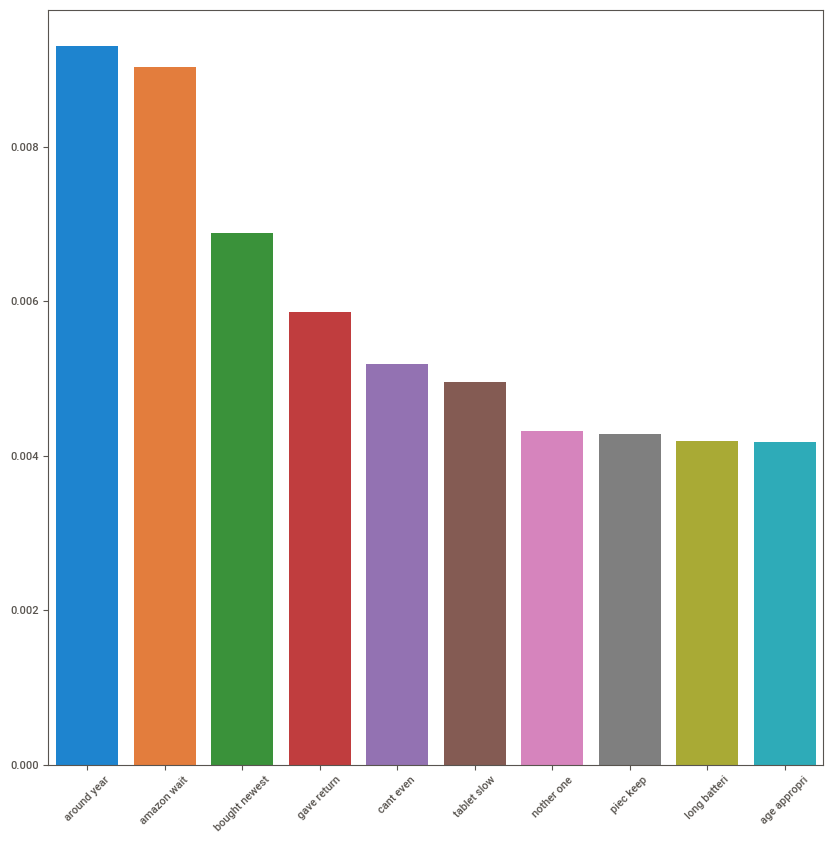

In [122]:
plt.figure(figsize=(10,10))
sns.barplot(names, value)
plt.xticks(rotation = 45)
plt.show()

From the graph it shows that these are the top 10 words that are mainly impacting the decision of the review 

## Week 2 Task

## C. Model Selection:

### 1. Apply multi-class SVM’s and neural nets.

#### 1.1 Applying multi-class SVM

In [123]:
print(x_train_txt_vec.shape)
print(y_train.shape)
print(x_test_txt_vec.shape)
print(y_test.shape)
print(x_test_hidden_vec.shape)
print(y_test_hidden.shape)

(2381, 3724)
(2381,)
(1021, 3724)
(1021,)
(1000, 3724)
(1000,)


In [124]:
from sklearn.svm import LinearSVC
l_svc = LinearSVC()
l_svc.fit(x_train_txt_vec, y_train)

LinearSVC()

In [125]:
# Model evaluation (SVM)
y_train_pred_svc = l_svc.predict(x_train_txt_vec)
y_test_pred_svc = l_svc.predict(x_test_txt_vec)

In [126]:
y_train_pred_svc

array(['Negative', 'Positive', 'Negative', ..., 'Negative', 'Neutral',
       'Neutral'], dtype=object)

Accuracy score Train 0.989920201595968
Accuracy score Test 0.9245837414299706

Train Classification Report: Multi-Class SVM - Linear SVC on Balanced data

              precision    recall  f1-score   support

    Negative       1.00      0.97      0.99       755
     Neutral       1.00      1.00      1.00       802
    Positive       0.97      1.00      0.99       824

    accuracy                           0.99      2381
   macro avg       0.99      0.99      0.99      2381
weighted avg       0.99      0.99      0.99      2381


Test Classification Report: Multi-Class SVM - Linear SVC on Balanced data

              precision    recall  f1-score   support

    Negative       0.96      0.94      0.95       323
     Neutral       0.93      0.93      0.93       344
    Positive       0.89      0.91      0.90       354

    accuracy                           0.92      1021
   macro avg       0.93      0.93      0.93      1021
weighted avg       0.92      0.92      0.92      1021


Train 

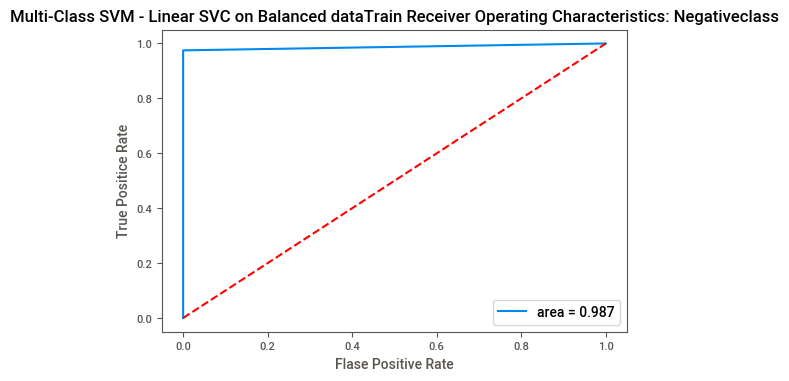

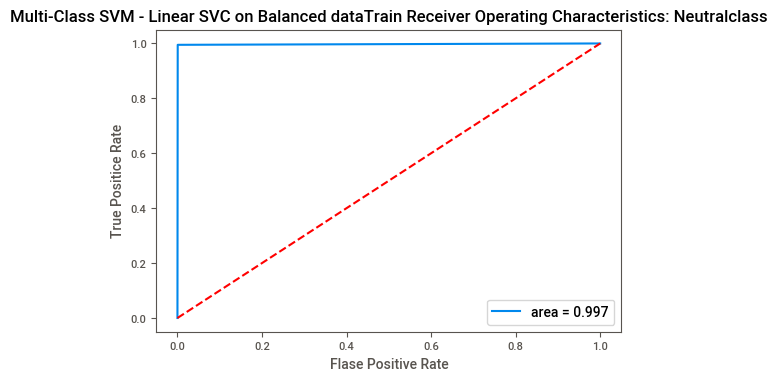

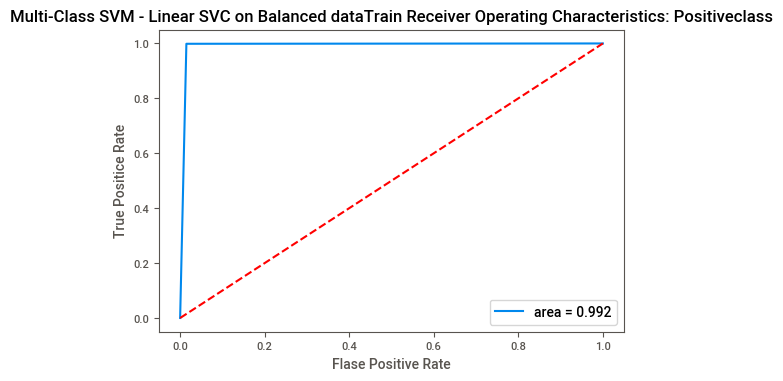


Roc AUC score test class Negative: 0.9874172185430463

Roc AUC score test class Neutral: 0.9971895783025022

Roc AUC score test class Positive: 0.9920072051680168


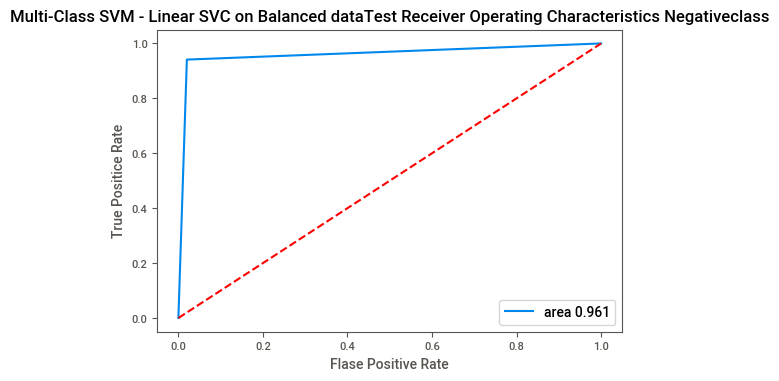

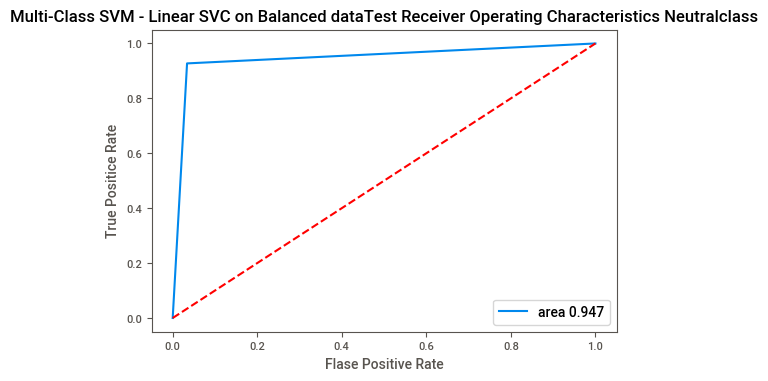

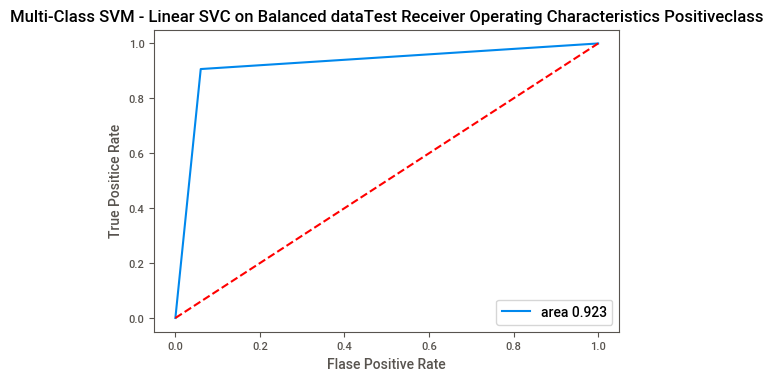

In [127]:
# Performance of Linear SVC
getPerformance(y_train, y_train_pred_svc, y_test, y_test_pred_svc, classes, 'Multi-Class SVM - Linear SVC on Balanced data')

In [128]:
y_test_hidden_predicted_svc = l_svc.predict(x_test_hidden_vec)
# y_test_hidden_predicted_decoded_xgb = decodeLabels(y_test_hidden_predicted_xgb)

print('Multi-class SVM - Linear SVC on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_svc)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_svc))

Multi-class SVM - Linear SVC on Hidden data 

Hidden data Test Accuracy score 0.891 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.22      0.42      0.29        24
     Neutral       0.27      0.36      0.31        39
    Positive       0.96      0.93      0.94       937

    accuracy                           0.89      1000
   macro avg       0.48      0.57      0.51      1000
weighted avg       0.92      0.89      0.90      1000



#### 1.2 Applying Neural Nets

To apply neural nets we need to encode the text labels into numeric by using label encoder.

In [129]:
from keras.utils.np_utils import to_categorical

In [130]:
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)
print(y_test)
print(y_test_enc)

2010     Neutral
241      Neutral
2637    Negative
518      Neutral
1520    Positive
          ...   
891     Negative
1117    Positive
918     Positive
2895    Negative
688     Positive
Name: sentiment, Length: 1021, dtype: object
[1 1 0 ... 2 0 2]


As per above encoding 

0 - Negative

1 - Neutral

2 - Positive

In [131]:
# Neural network architecture
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
model = Sequential()
model.add(Dense(2048, input_dim = x_train_txt_vec.shape[1], activation = 'relu')) # 12 neurons in layer 1, with 8 input dimension
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))                # 32 neurons in layer 2
model.add(Dense(3, activation = 'softmax'))             # 3 neuron in output layer as it is binary classification
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [132]:
# Model training
model.fit(x_train_txt_vec, y_train_enc, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
75/75 - 13s - loss: 0.9798 - accuracy: 0.4376 - 13s/epoch - 169ms/step
Epoch 2/50
75/75 - 8s - loss: 0.2988 - accuracy: 0.8870 - 8s/epoch - 107ms/step
Epoch 3/50
75/75 - 8s - loss: 0.0933 - accuracy: 0.9698 - 8s/epoch - 104ms/step
Epoch 4/50
75/75 - 8s - loss: 0.0435 - accuracy: 0.9861 - 8s/epoch - 107ms/step
Epoch 5/50
75/75 - 8s - loss: 0.0329 - accuracy: 0.9899 - 8s/epoch - 106ms/step
Epoch 6/50
75/75 - 7s - loss: 0.0297 - accuracy: 0.9903 - 7s/epoch - 98ms/step
Epoch 7/50
75/75 - 8s - loss: 0.0302 - accuracy: 0.9903 - 8s/epoch - 104ms/step
Epoch 8/50
75/75 - 8s - loss: 0.0428 - accuracy: 0.9849 - 8s/epoch - 105ms/step
Epoch 9/50
75/75 - 8s - loss: 0.0509 - accuracy: 0.9882 - 8s/epoch - 101ms/step
Epoch 10/50
75/75 - 7s - loss: 0.0417 - accuracy: 0.9882 - 7s/epoch - 99ms/step
Epoch 11/50
75/75 - 7s - loss: 0.0332 - accuracy: 0.9895 - 7s/epoch - 99ms/step
Epoch 12/50
75/75 - 8s - loss: 0.0296 - accuracy: 0.9903 - 8s/epoch - 102ms/step
Epoch 13/50
75/75 - 7s - loss: 0.0285 

In [133]:
# Model evaluation (SVM)
loss, accuracy = model.evaluate(x_test_txt_vec,y_test_enc)

32/32 [==============================] - 3s 10ms/step - loss: 1.0140 - accuracy: 0.9324


In [134]:
print("Neural Net model loss    : ", loss)
print("Neural Net model accuracy: ", accuracy)

Neural Net model loss    :  1.0139555931091309
Neural Net model accuracy:  0.9324191808700562


In [135]:
# nn_predict_test = model.predict(x_train)

In [136]:
y_train_pred_NN = model.predict(x_train_txt_vec)
y_test_pred_NN = model.predict(x_test_txt_vec)

32/32 [==============================] - 0s 13ms/step


In [137]:
y_train_pred_NN

array([[1.0000000e+00, 6.7703589e-33, 4.1261578e-38],
       [3.3979177e-09, 1.4943684e-21, 1.0000000e+00],
       [1.0000000e+00, 8.9039722e-36, 0.0000000e+00],
       ...,
       [1.0000000e+00, 4.1858255e-18, 7.4904920e-21],
       [0.0000000e+00, 1.0000000e+00, 1.1781187e-20],
       [0.0000000e+00, 1.0000000e+00, 1.0958740e-16]], dtype=float32)

In [138]:
y_train_pred_NN_labels = np.argmax(y_train_pred_NN, axis=-1)
y_test_pred_NN_labels = np.argmax(y_test_pred_NN, axis=-1)
print(y_train_pred_NN_labels)
print(y_test_pred_NN_labels)

[0 2 0 ... 0 1 1]
[1 1 0 ... 2 0 2]


In [139]:
np.unique(y_train_pred_NN_labels)

array([0, 1, 2], dtype=int64)

In [140]:
y_train_pred_NN_decoded_labels = decodeLabels(y_train_pred_NN_labels)
y_test_pred_NN_decoded_labels = decodeLabels(y_test_pred_NN_labels)
print(y_train_pred_NN_decoded_labels)
print(y_test_pred_NN_decoded_labels)

['Negative' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Neutral']
['Neutral' 'Neutral' 'Negative' ... 'Positive' 'Negative' 'Positive']


Neural Net Performance
Accuracy score Train 0.9903401931961361
Accuracy score Test 0.9324191968658179

Train Classification Report: Neural Network

              precision    recall  f1-score   support

    Negative       1.00      0.97      0.99       755
     Neutral       1.00      1.00      1.00       802
    Positive       0.97      1.00      0.99       824

    accuracy                           0.99      2381
   macro avg       0.99      0.99      0.99      2381
weighted avg       0.99      0.99      0.99      2381


Test Classification Report: Neural Network

              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96       323
     Neutral       0.92      0.94      0.93       344
    Positive       0.90      0.92      0.91       354

    accuracy                           0.93      1021
   macro avg       0.93      0.93      0.93      1021
weighted avg       0.93      0.93      0.93      1021


Train Confusion matrix: Neural Network

    

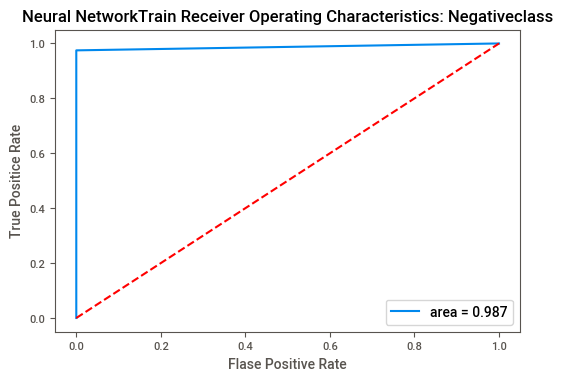

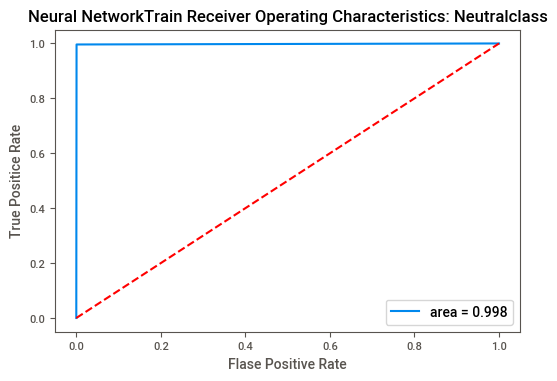

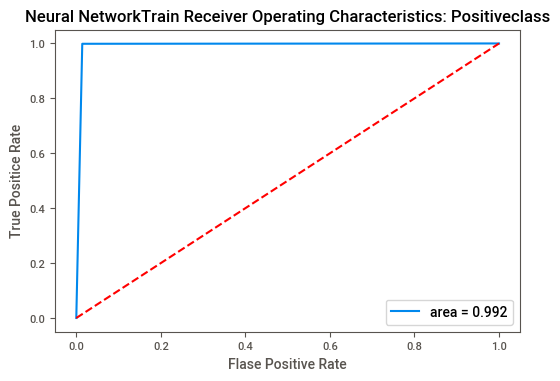


Roc AUC score test class Negative: 0.9874172185430463

Roc AUC score test class Neutral: 0.9978130196990108

Roc AUC score test class Positive: 0.9923283355469505


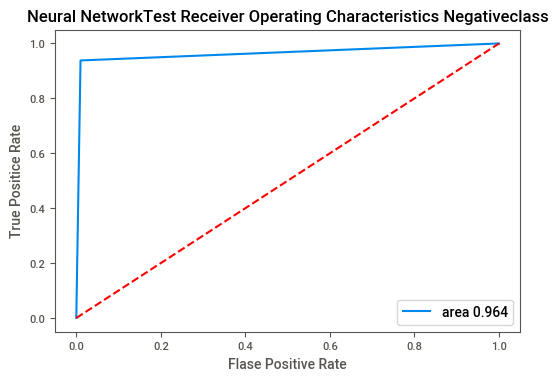

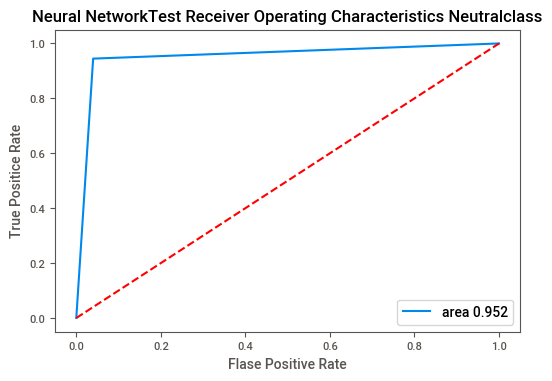

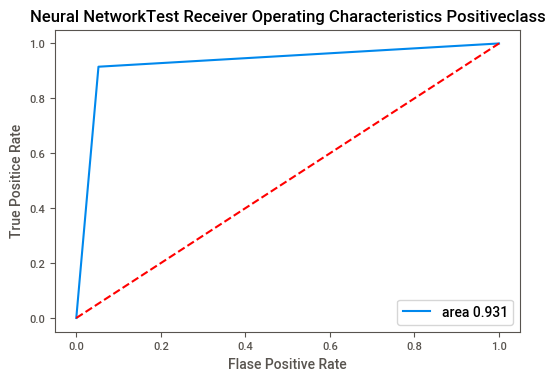

In [141]:
print('Neural Net Performance')
getPerformance(y_train, y_train_pred_NN_decoded_labels, y_test, y_test_pred_NN_decoded_labels, classes, 'Neural Network')

In [142]:
y_test_hidden_predicted_NN = model.predict(x_test_hidden_vec)

y_train_hidden_NN_labels = np.argmax(y_test_hidden_predicted_NN, axis=-1)

y_train_hidden_NN_labels_decoded = decodeLabels(y_train_hidden_NN_labels)

print('Neural Net on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_train_hidden_NN_labels_decoded)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_train_hidden_NN_labels_decoded))

32/32 [==============================] - 0s 7ms/step
Neural Net on Hidden data 

Hidden data Test Accuracy score 0.874 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.30      0.42      0.35        24
     Neutral       0.18      0.38      0.25        39
    Positive       0.96      0.91      0.93       937

    accuracy                           0.87      1000
   macro avg       0.48      0.57      0.51      1000
weighted avg       0.91      0.87      0.89      1000



##### 3. Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

In [143]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [144]:
x_train_txt.head()

2770    kindl card overload app never use despit one b...
884                               son love easi use great
2565    review amazon seem awesom littl know chronic p...
2811    wast lot money ask alexa question quick hope r...
933     happi enough first batteri almost total dead r...
Name: reviews_clean_text, dtype: object

In [145]:
def fn_assign_sentiment_score(X):
    
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = [sia.polarity_scores(review)['compound'] for review in X]
    sentiment_scores = np.array(sentiment_scores).reshape(-1, 1)
    
    return sentiment_scores


In [146]:
x_train_txt_SC = fn_assign_sentiment_score(x_train_txt)
x_test_txt_SC = fn_assign_sentiment_score(x_test_txt)
x_hidden_txt_SC = fn_assign_sentiment_score(df_test_hidden['reviews_clean_text'])

In [147]:
print('Train txt shape     :', x_train_txt.shape)
print('Train txt sc shape  :', x_train_txt_SC.shape)
print('Test txt shape      :', x_test_txt.shape)
print('Test txt sc shape   :', x_test_txt_SC.shape)
print('Hidden txt sc shape :', df_test_hidden['reviews_clean_text'].shape)
print('Hidden txt sc shape :', x_hidden_txt_SC.shape)


Train txt shape     : (2381,)
Train txt sc shape  : (2381, 1)
Test txt shape      : (1021,)
Test txt sc shape   : (1021, 1)
Hidden txt sc shape : (1000,)
Hidden txt sc shape : (1000, 1)


In [148]:
# Combine the sentiment scores with the vectorized text as a new feature
x_train_txt_vec_with_sc = np.hstack((x_train_txt_vec.toarray(), x_train_txt_SC))
x_test_txt_vec_with_sc = np.hstack((x_test_txt_vec.toarray(), x_test_txt_SC))
x_test_hidden_vec_with_sc = np.hstack((x_test_hidden_vec.toarray(), x_hidden_txt_SC))

In [149]:
print(x_train_txt_vec.shape)
print(x_train_txt_SC.shape)
print(x_test_txt.shape)
print(x_test_txt_SC.shape)
print(x_test_hidden_vec.shape)
print(x_hidden_txt_SC.shape)
print(x_train_txt_vec_with_sc.shape)
print(y_train.shape)
print(x_test_txt_vec_with_sc.shape)
print(y_test.shape)
print(x_test_hidden_vec_with_sc.shape)

(2381, 3724)
(2381, 1)
(1021,)
(1021, 1)
(1000, 3724)
(1000, 1)
(2381, 3725)
(2381,)
(1021, 3725)
(1021,)
(1000, 3725)


In [150]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',gridsearch_nb)])
p.fit(x_train_txt_vec_with_sc,y_train) 

Pipeline(steps=[('Normalizing', MinMaxScaler()),
                ('MultinomialNB',
                 GridSearchCV(estimator=MultinomialNB(),
                              param_grid={'alpha': [0.001, 0.005, 0.1, 0.5, 1]},
                              scoring=make_scorer(f1_score, average=macro)))])

#### 3.1 Gridsearch with Multinomial NB with Sentiment Score

In [151]:
y_train_txt_sc_pred_pipeline = p.predict(x_train_txt_vec_with_sc)
y_test_txt_sc_pred_pipeline = p.predict(x_test_txt_vec_with_sc)

Accuracy score Train 0.9664006719865603
Accuracy score Test 0.8863858961802155

Train Classification Report: Naive Bayes Balanced with Sentiment Score Pipeline

              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       755
     Neutral       1.00      0.96      0.98       802
    Positive       0.91      1.00      0.96       824

    accuracy                           0.97      2381
   macro avg       0.97      0.97      0.97      2381
weighted avg       0.97      0.97      0.97      2381


Test Classification Report: Naive Bayes Balanced with Sentiment Score Pipeline

              precision    recall  f1-score   support

    Negative       0.94      0.91      0.92       323
     Neutral       0.89      0.90      0.89       344
    Positive       0.83      0.86      0.85       354

    accuracy                           0.89      1021
   macro avg       0.89      0.89      0.89      1021
weighted avg       0.89      0.89      0.89      10

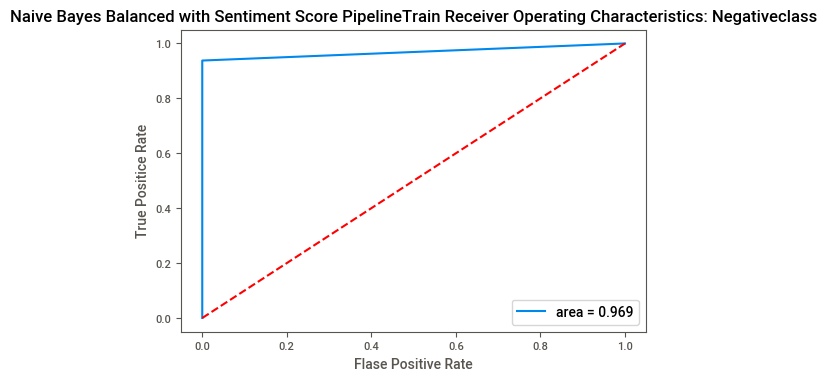

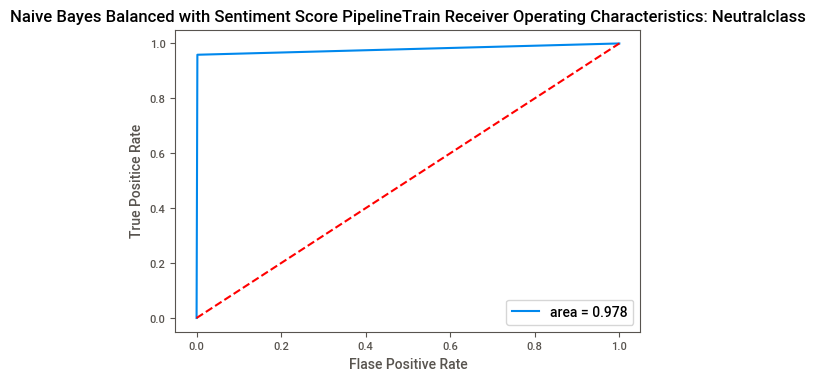

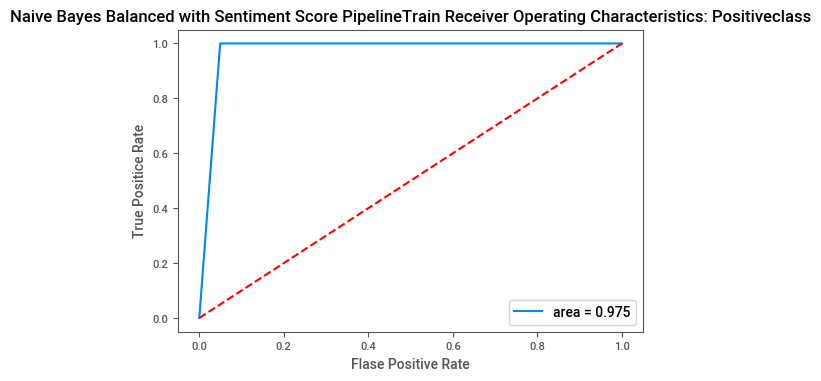


Roc AUC score test class Negative: 0.9688741721854305

Roc AUC score test class Neutral: 0.978476465580823

Roc AUC score test class Positive: 0.9752729608220937


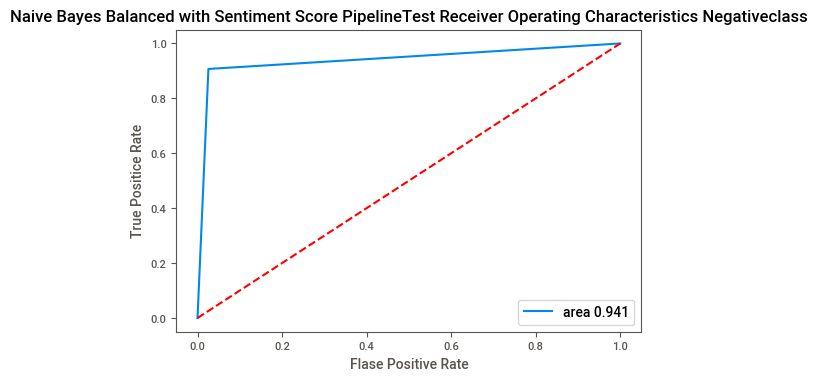

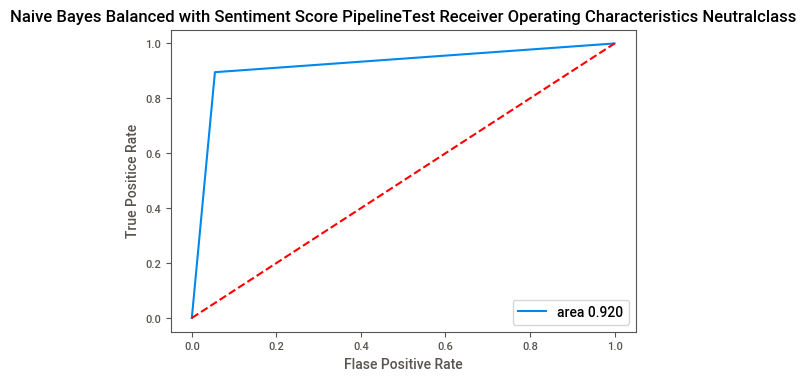

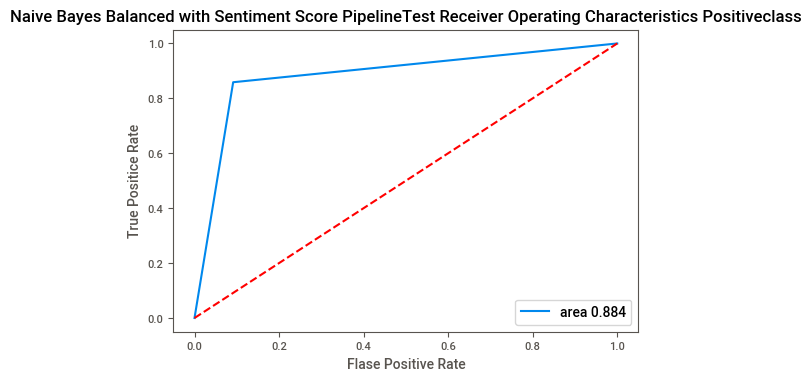

In [152]:
getPerformance(y_train, y_train_txt_sc_pred_pipeline, y_test, y_test_txt_sc_pred_pipeline, classes, 'Naive Bayes Balanced with Sentiment Score Pipeline')

In [153]:
y_train_txt_sc_pred_MNB = gridsearch_nb.predict(x_train_txt_vec_with_sc)
y_test_txt_sc_pred_MNB = gridsearch_nb.predict(x_test_txt_vec_with_sc)

Gridsearch - Multinomial Naive Bayes performance on data with Sentiment Score
Accuracy score Train 0.9622007559848803
Accuracy score Test 0.8991185112634672

Train Classification Report: Naive Bayes Balanced with Sentiment Score

              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       755
     Neutral       0.99      0.95      0.97       802
    Positive       0.91      0.99      0.95       824

    accuracy                           0.96      2381
   macro avg       0.97      0.96      0.96      2381
weighted avg       0.96      0.96      0.96      2381


Test Classification Report: Naive Bayes Balanced with Sentiment Score

              precision    recall  f1-score   support

    Negative       0.97      0.92      0.94       323
     Neutral       0.93      0.86      0.89       344
    Positive       0.82      0.92      0.87       354

    accuracy                           0.90      1021
   macro avg       0.91      0.90      0.90  

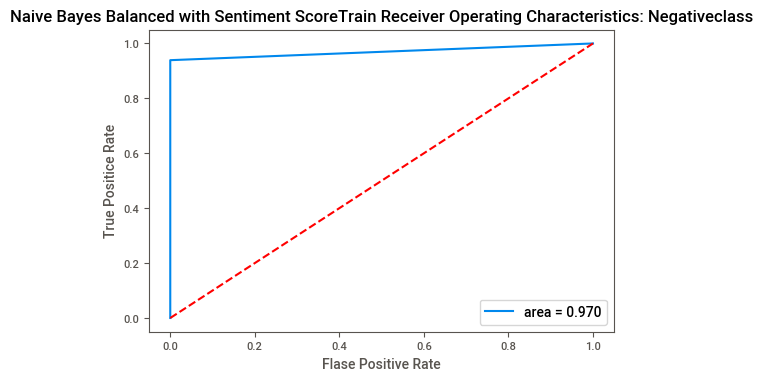

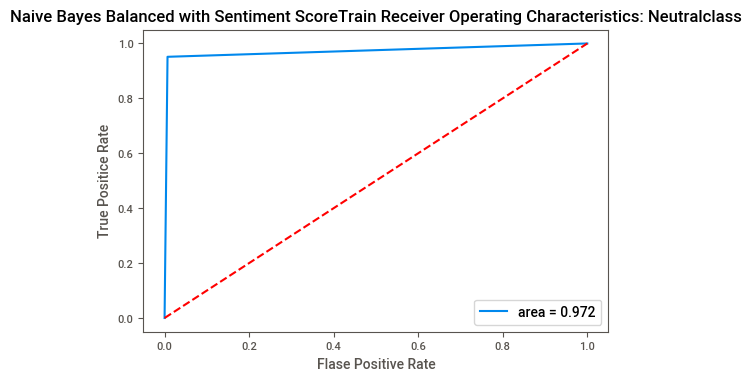

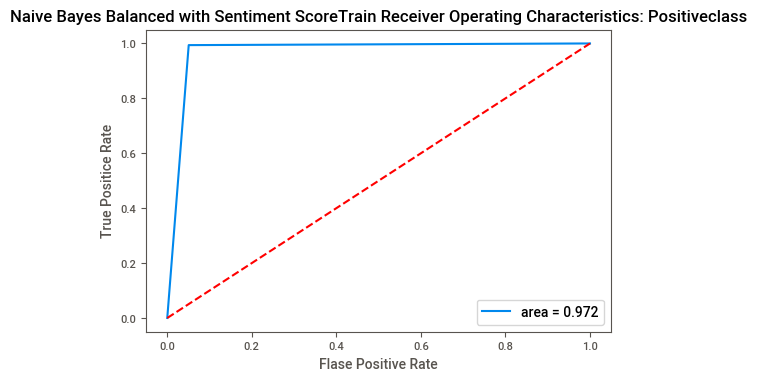


Roc AUC score test class Negative: 0.9695364238410595

Roc AUC score test class Neutral: 0.9722025683100671

Roc AUC score test class Positive: 0.9715967194817018


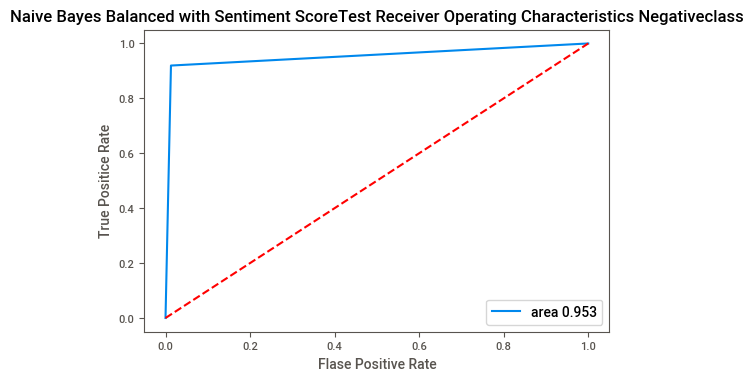

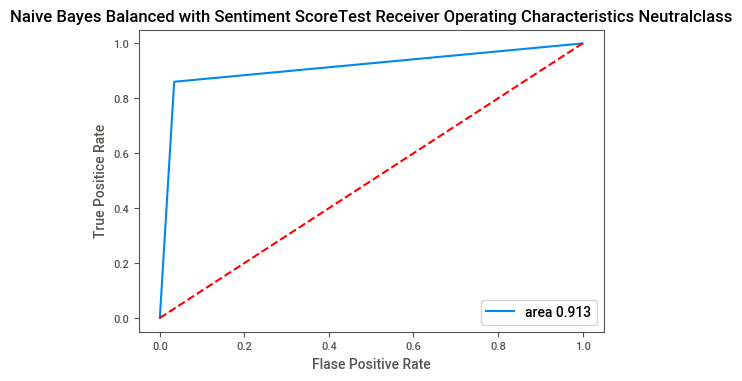

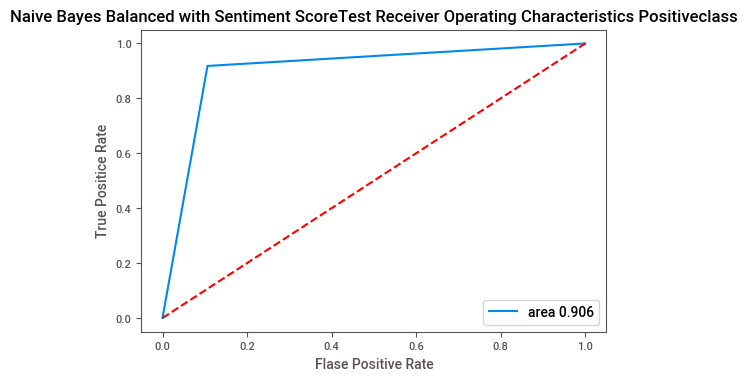

In [154]:
print('Gridsearch - Multinomial Naive Bayes performance on data with Sentiment Score')
getPerformance(y_train, y_train_txt_sc_pred_MNB, y_test, y_test_txt_sc_pred_MNB, classes, 'Naive Bayes Balanced with Sentiment Score')

In [155]:
print("Multinomial NB Pipeline with MinMax Scalar with Sentiment Score on Hidden data \n")
y_test_hidden_predicted_pipe_MNB = p.predict(x_test_hidden_vec_with_sc)
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_pipe_MNB)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_pipe_MNB))

Multinomial NB Pipeline with MinMax Scalar with Sentiment Score on Hidden data 

Hidden data Test Accuracy score 0.803 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.14      0.50      0.22        24
     Neutral       0.13      0.36      0.19        39
    Positive       0.96      0.83      0.89       937

    accuracy                           0.80      1000
   macro avg       0.41      0.56      0.43      1000
weighted avg       0.91      0.80      0.85      1000



In [156]:
print("Multinomial NB with Sentiment Score on Hidden data \n")
y_test_hidden_predicted_MNB = gridsearch_nb.predict(x_test_hidden_vec_with_sc)
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_MNB)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_MNB))

Multinomial NB with Sentiment Score on Hidden data 

Hidden data Test Accuracy score 0.871 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.22      0.42      0.29        24
     Neutral       0.19      0.36      0.25        39
    Positive       0.96      0.90      0.93       937

    accuracy                           0.87      1000
   macro avg       0.46      0.56      0.49      1000
weighted avg       0.92      0.87      0.89      1000



#### The f1-score macro average slightly inproved from .47 to .52 after using sentiment score with Multinomial Naive Bayes classifier. 

#### 3.2 Gridsearch - Random Forest on data with Sentiment Score

In [157]:
gs_rf.fit(x_train_txt_vec_with_sc, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(f1_score, average=macro))

In [158]:
y_train_txt_sc_pred_rf = gs_rf.predict(x_train_txt_vec_with_sc)
y_test_txt_sc_pred_rf = gs_rf.predict(x_test_txt_vec_with_sc)

Gridsearch - Random Forest performance on data with Sentiment Score
Accuracy score Train 0.6904661906761865
Accuracy score Test 0.6317335945151812

Train Classification Report: Random Forest with Sentiment Score

              precision    recall  f1-score   support

    Negative       0.67      0.85      0.75       755
     Neutral       1.00      0.50      0.66       802
    Positive       0.59      0.74      0.65       824

    accuracy                           0.69      2381
   macro avg       0.75      0.69      0.69      2381
weighted avg       0.75      0.69      0.69      2381


Test Classification Report: Random Forest with Sentiment Score

              precision    recall  f1-score   support

    Negative       0.64      0.82      0.72       323
     Neutral       0.96      0.37      0.54       344
    Positive       0.54      0.71      0.61       354

    accuracy                           0.63      1021
   macro avg       0.71      0.63      0.62      1021
weighted avg   

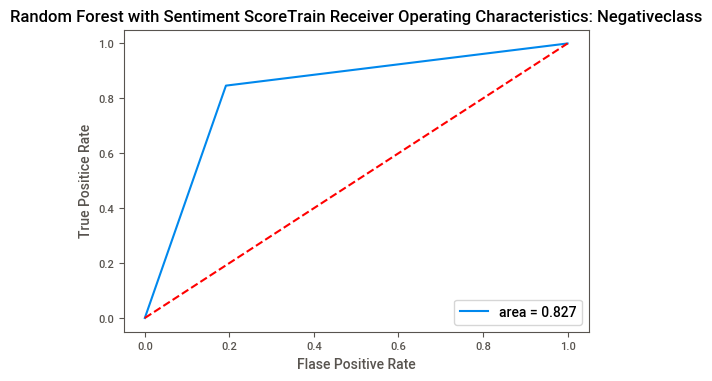

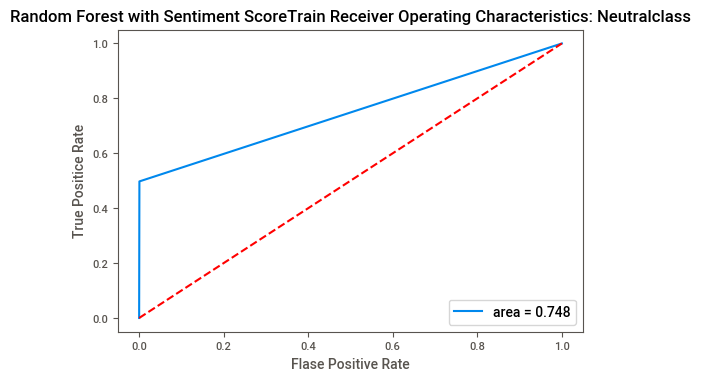

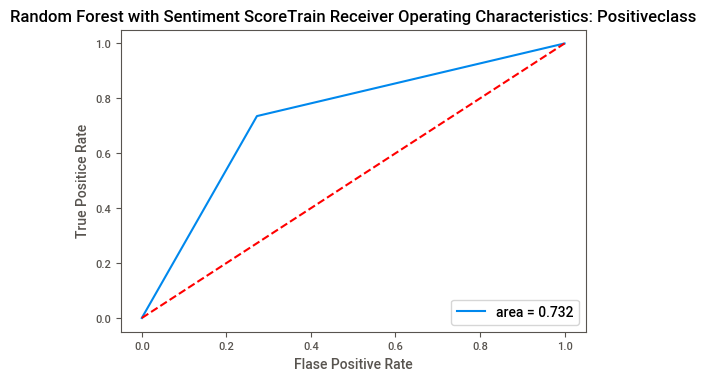


Roc AUC score test class Negative: 0.8272378485374257

Roc AUC score test class Neutral: 0.7484364610955195

Roc AUC score test class Positive: 0.7315591659339906


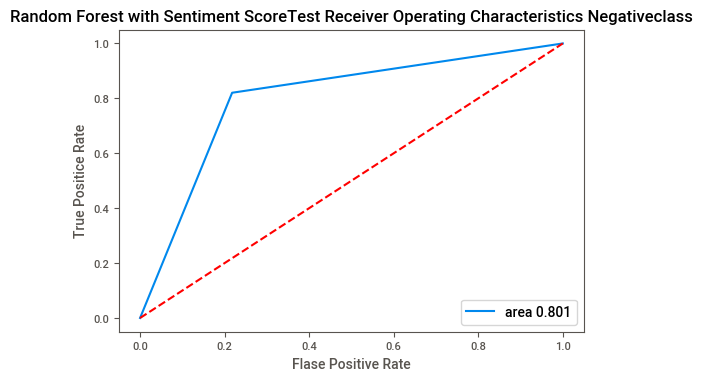

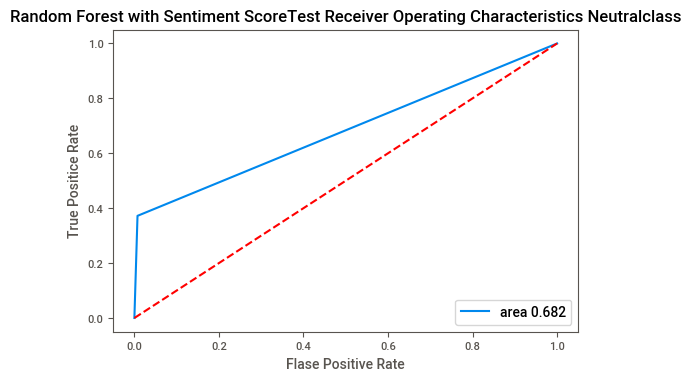

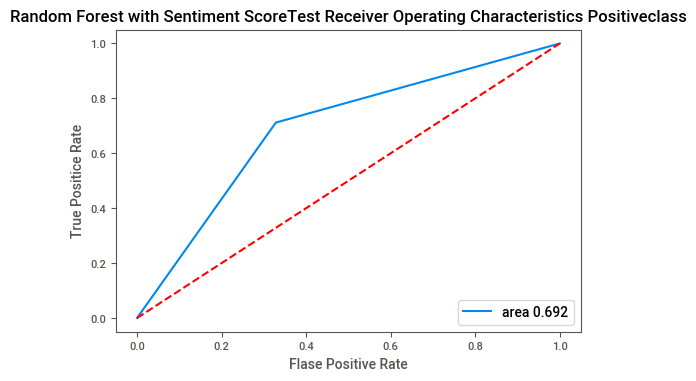

In [159]:
print('Gridsearch - Random Forest performance on data with Sentiment Score')
getPerformance(y_train, y_train_txt_sc_pred_rf, y_test, y_test_txt_sc_pred_rf, classes, 'Random Forest with Sentiment Score')

In [160]:
print("Random Forest with Sentiment Score on Hidden data \n")
y_test_hidden_predicted_rf = gs_rf.predict(x_test_hidden_vec_with_sc)
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_rf)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_rf))

Random Forest with Sentiment Score on Hidden data 

Hidden data Test Accuracy score 0.714 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.07      0.75      0.12        24
     Neutral       0.33      0.08      0.12        39
    Positive       0.97      0.74      0.84       937

    accuracy                           0.71      1000
   macro avg       0.45      0.52      0.36      1000
weighted avg       0.92      0.71      0.79      1000



#### 3.3 Gridsearch - XGBoost using Sentiment Score dataset

In [161]:
gs_xgbc.fit(x_train_txt_vec_with_sc,y_train_lb_enc)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'gamma': [0.001, 0.01, 0.1], 'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(f1_score, average=macro))

In [162]:
y_train_txt_sc_pred_XGB = gs_xgbc.predict(x_train_txt_vec_with_sc)
y_test_txt_sc_pred_XGB = gs_xgbc.predict(x_test_txt_vec_with_sc)
y_train_txt_sc_pred_decoded_XGB = decodeLabels(y_train_txt_sc_pred_XGB)
y_test_txt_sc_pred_decoded_XGB = decodeLabels(y_test_txt_sc_pred_XGB)

Gridsearch - XGboost performance on data with Sentiment Score
Accuracy score Train 0.9760604787904242
Accuracy score Test 0.8697355533790402

Train Classification Report: XGboost with Sentiment Score

              precision    recall  f1-score   support

    Negative       1.00      0.95      0.97       755
     Neutral       1.00      0.99      0.99       802
    Positive       0.94      1.00      0.97       824

    accuracy                           0.98      2381
   macro avg       0.98      0.98      0.98      2381
weighted avg       0.98      0.98      0.98      2381


Test Classification Report: XGboost with Sentiment Score

              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90       323
     Neutral       0.94      0.82      0.88       344
    Positive       0.78      0.89      0.83       354

    accuracy                           0.87      1021
   macro avg       0.88      0.87      0.87      1021
weighted avg       0.88      0.87

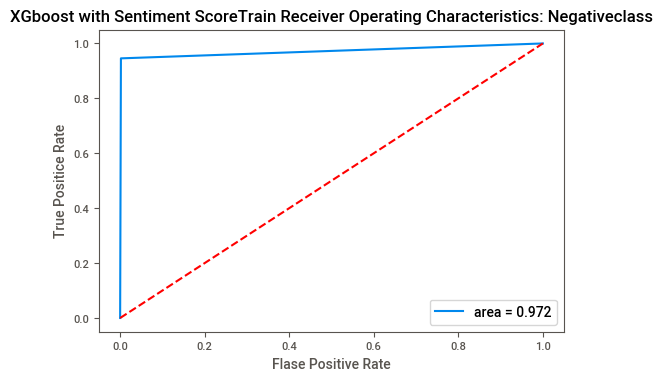

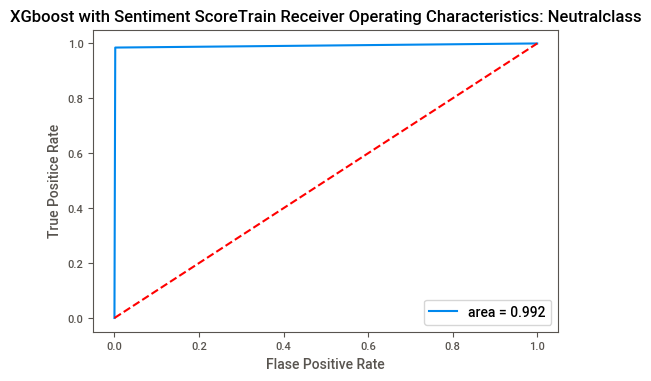

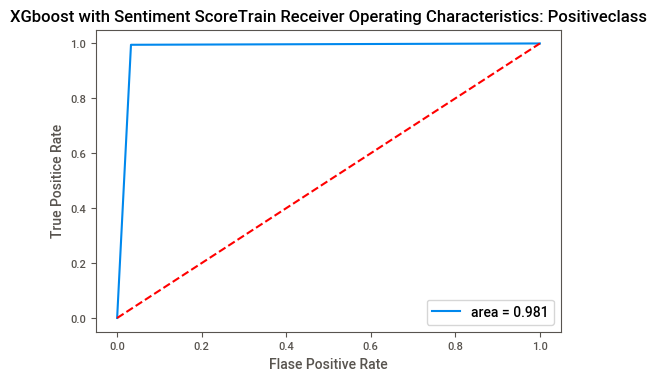


Roc AUC score test class Negative: 0.9719251728941132

Roc AUC score test class Neutral: 0.9915687349075064

Roc AUC score test class Positive: 0.9811951662083545


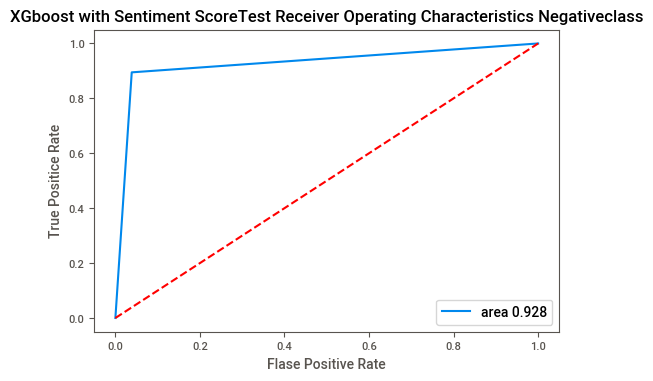

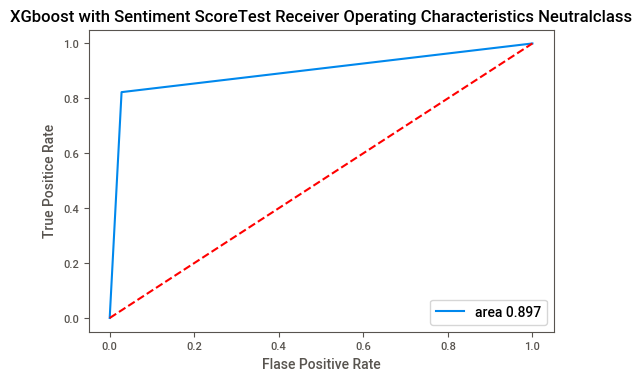

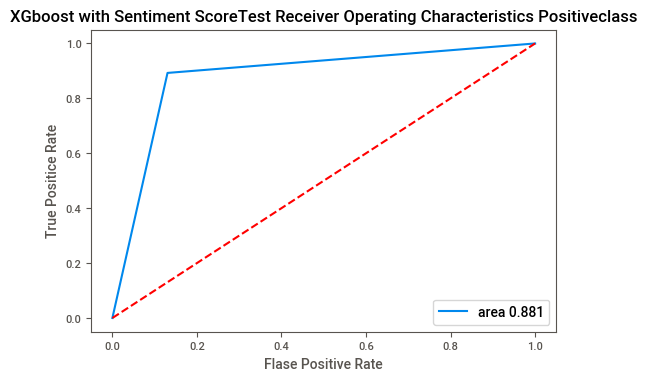

In [163]:
print('Gridsearch - XGboost performance on data with Sentiment Score')
getPerformance(y_train, y_train_txt_sc_pred_decoded_XGB, y_test, y_test_txt_sc_pred_decoded_XGB, classes, 'XGboost with Sentiment Score')

In [164]:
y_test_hidden.shape

(1000,)

In [165]:
print("XGBoost with Sentiment Score on Hidden data with sentiment score \n")
y_test_hidden_predicted_XGB = gs_xgbc.predict(x_test_hidden_vec_with_sc)
y_test_hidden_predicted_decoded_XGB = decodeLabels(y_test_hidden_predicted_XGB)

print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_predicted_decoded_XGB)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_predicted_decoded_XGB))

XGBoost with Sentiment Score on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.896 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.20      0.42      0.27        24
     Neutral       0.31      0.36      0.33        39
    Positive       0.96      0.93      0.95       937

    accuracy                           0.90      1000
   macro avg       0.49      0.57      0.52      1000
weighted avg       0.92      0.90      0.91      1000



#### 3.4 Multiclass SVM on hidden data with Sentiment socre

In [166]:
l_svc.fit(x_train_txt_vec_with_sc,y_train)

LinearSVC()

Accuracy score Train 0.9903401931961361
Accuracy score Test 0.9226248775710089

Train Classification Report: Multi-Class SVM - Linear SVC on Balanced data with Sentiment score

              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       755
     Neutral       1.00      1.00      1.00       802
    Positive       0.97      1.00      0.99       824

    accuracy                           0.99      2381
   macro avg       0.99      0.99      0.99      2381
weighted avg       0.99      0.99      0.99      2381


Test Classification Report: Multi-Class SVM - Linear SVC on Balanced data with Sentiment score

              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94       323
     Neutral       0.94      0.93      0.93       344
    Positive       0.88      0.91      0.90       354

    accuracy                           0.92      1021
   macro avg       0.92      0.92      0.92      1021
weighted avg       

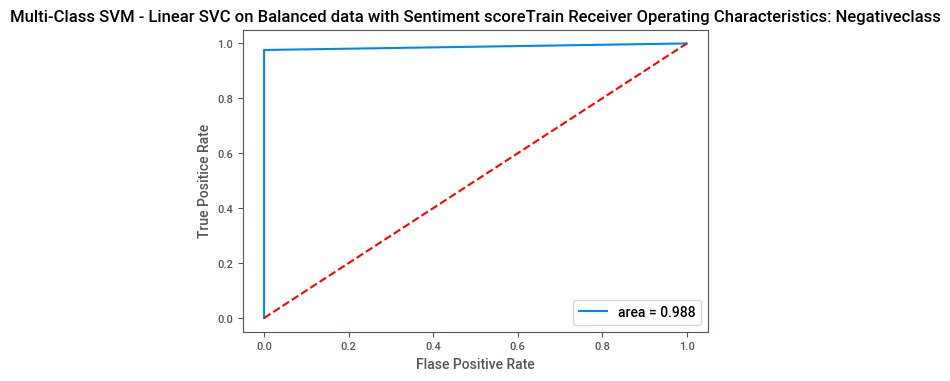

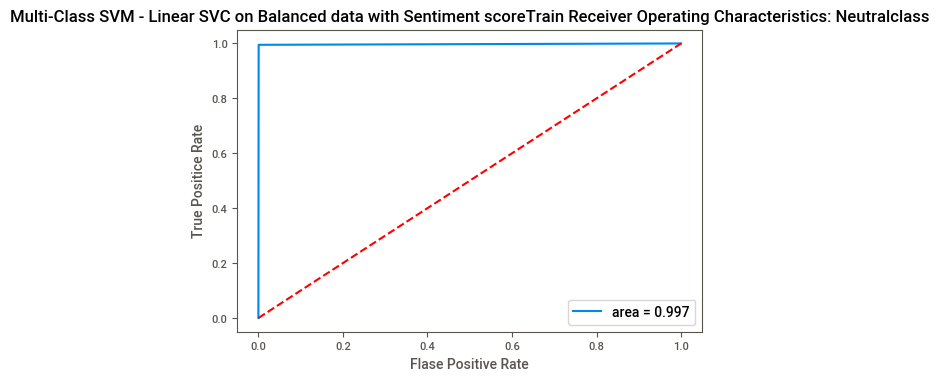

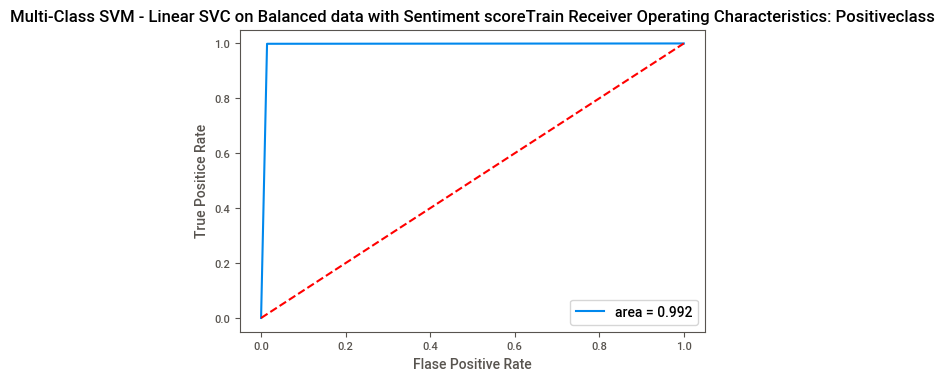


Roc AUC score test class Negative: 0.9880794701986755

Roc AUC score test class Neutral: 0.9971895783025022

Roc AUC score test class Positive: 0.9923283355469505


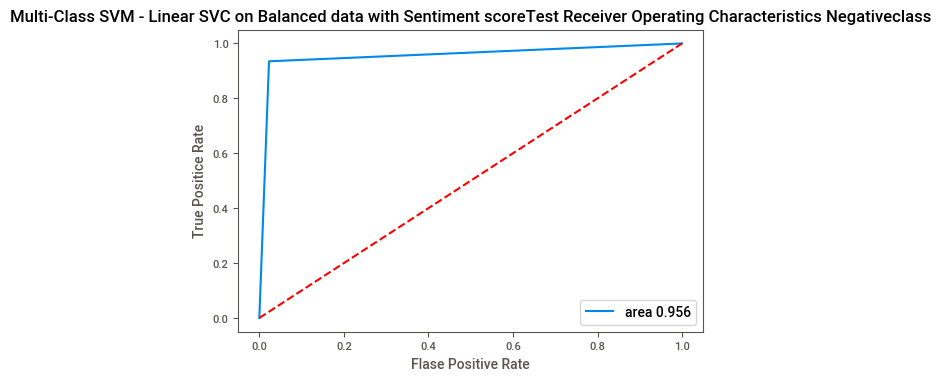

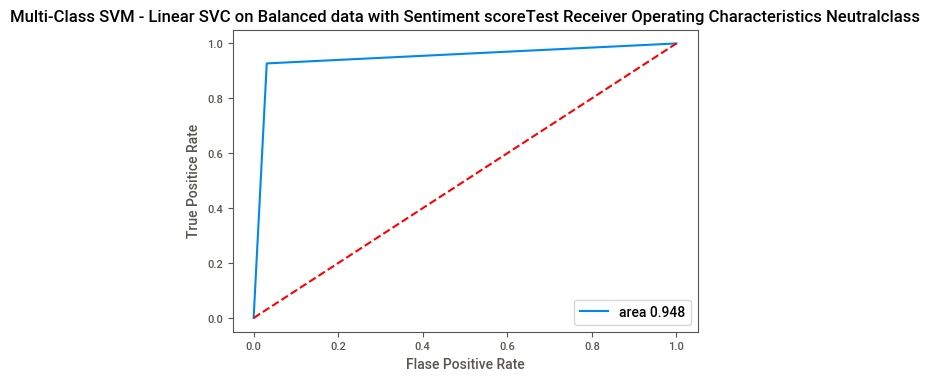

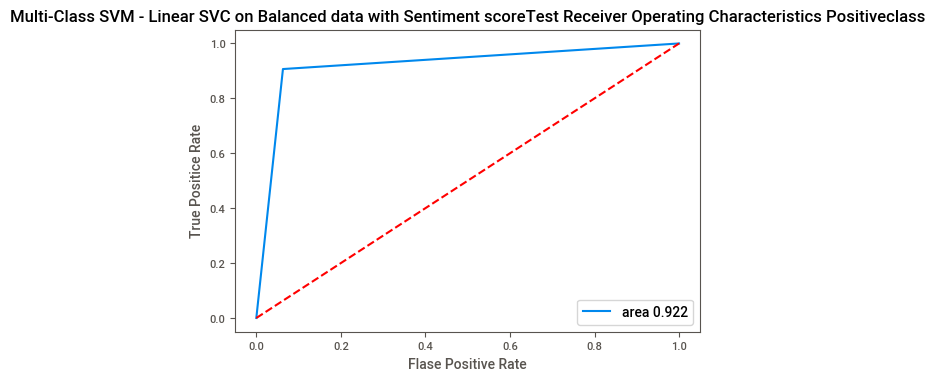

In [167]:
# Model evaluation (SVM)
y_train_sc_pred_svc = l_svc.predict(x_train_txt_vec_with_sc)
y_test_sc_pred_svc = l_svc.predict(x_test_txt_vec_with_sc)
# Performance of Linear SVC
getPerformance(y_train, y_train_sc_pred_svc, y_test, y_test_sc_pred_svc, classes, 'Multi-Class SVM - Linear SVC on Balanced data with Sentiment score')

In [168]:
print("Multiclass Linear with Sentiment Score on Hidden data with sentiment score \n")
y_test_hidden_sc_pred_svc = l_svc.predict(x_test_hidden_vec_with_sc)
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hidden_sc_pred_svc)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hidden_sc_pred_svc))

Multiclass Linear with Sentiment Score on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.892 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.23      0.46      0.31        24
     Neutral       0.27      0.36      0.31        39
    Positive       0.96      0.93      0.94       937

    accuracy                           0.89      1000
   macro avg       0.49      0.58      0.52      1000
weighted avg       0.92      0.89      0.90      1000



#### 3.5 Neural Net on hidden data with Sentiment socre

In [267]:
# Neural network architecture
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
model = Sequential()
model.add(Dense(2048, input_dim = x_train_txt_vec_with_sc.shape[1], activation = 'relu')) # 12 neurons in layer 1, with 8 input dimension
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))                # 64 neurons in layer 2
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))                # 32 neurons in layer 2
model.add(Dense(3, activation = 'softmax'))             # 3 neuron in output layer as it is binary classification
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [268]:
# Model training
model.fit(x_train_txt_vec_with_sc,y_train_lb_enc, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
75/75 - 6s - loss: 0.8999 - accuracy: 0.5191 - 6s/epoch - 80ms/step
Epoch 2/50
75/75 - 5s - loss: 0.2653 - accuracy: 0.9097 - 5s/epoch - 69ms/step
Epoch 3/50
75/75 - 5s - loss: 0.0706 - accuracy: 0.9777 - 5s/epoch - 72ms/step
Epoch 4/50
75/75 - 6s - loss: 0.0415 - accuracy: 0.9887 - 6s/epoch - 77ms/step
Epoch 5/50
75/75 - 6s - loss: 0.0362 - accuracy: 0.9891 - 6s/epoch - 76ms/step
Epoch 6/50
75/75 - 5s - loss: 0.0309 - accuracy: 0.9903 - 5s/epoch - 72ms/step
Epoch 7/50
75/75 - 6s - loss: 0.0336 - accuracy: 0.9903 - 6s/epoch - 82ms/step
Epoch 8/50
75/75 - 6s - loss: 0.0295 - accuracy: 0.9908 - 6s/epoch - 77ms/step
Epoch 9/50
75/75 - 6s - loss: 0.0326 - accuracy: 0.9895 - 6s/epoch - 82ms/step
Epoch 10/50
75/75 - 6s - loss: 0.0313 - accuracy: 0.9899 - 6s/epoch - 83ms/step
Epoch 11/50
75/75 - 6s - loss: 0.0298 - accuracy: 0.9903 - 6s/epoch - 84ms/step
Epoch 12/50
75/75 - 6s - loss: 0.0294 - accuracy: 0.9899 - 6s/epoch - 87ms/step
Epoch 13/50
75/75 - 6s - loss: 0.0294 - accuracy:

In [269]:
# Model evaluation (SVM)
loss, accuracy = model.evaluate(x_test_txt_vec_with_sc,y_test_enc)

32/32 [==============================] - 1s 29ms/step - loss: 1.1026 - accuracy: 0.9256


In [270]:
y_train_sc_pred_NN = model.predict(x_train_txt_vec_with_sc)
y_test_sc_pred_NN = model.predict(x_test_txt_vec_with_sc)

32/32 [==============================] - 1s 31ms/step


In [271]:
y_train_sc_pred_NN_labels = np.argmax(y_train_sc_pred_NN, axis=-1)
y_test_sc_pred_NN_labels = np.argmax(y_test_sc_pred_NN, axis=-1)
print(y_train_sc_pred_NN_labels)
print(y_test_sc_pred_NN_labels)

y_train_sc_pred_NN_decoded_labels = decodeLabels(y_train_sc_pred_NN_labels)
y_test_sc_pred_NN_decoded_labels = decodeLabels(y_test_sc_pred_NN_labels)
print(y_train_sc_pred_NN_decoded_labels)
print(y_test_sc_pred_NN_decoded_labels)

[0 2 0 ... 0 1 1]
[1 1 0 ... 2 0 2]
['Negative' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Neutral']
['Neutral' 'Neutral' 'Negative' ... 'Positive' 'Negative' 'Positive']


Neural Net Performance
Accuracy score Train 0.9916001679966401
Accuracy score Test 0.9255631733594515

Train Classification Report: Neural Network

              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       755
     Neutral       1.00      1.00      1.00       802
    Positive       0.98      1.00      0.99       824

    accuracy                           0.99      2381
   macro avg       0.99      0.99      0.99      2381
weighted avg       0.99      0.99      0.99      2381


Test Classification Report: Neural Network

              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93       323
     Neutral       0.96      0.93      0.94       344
    Positive       0.90      0.91      0.90       354

    accuracy                           0.93      1021
   macro avg       0.93      0.93      0.93      1021
weighted avg       0.93      0.93      0.93      1021


Train Confusion matrix: Neural Network

    

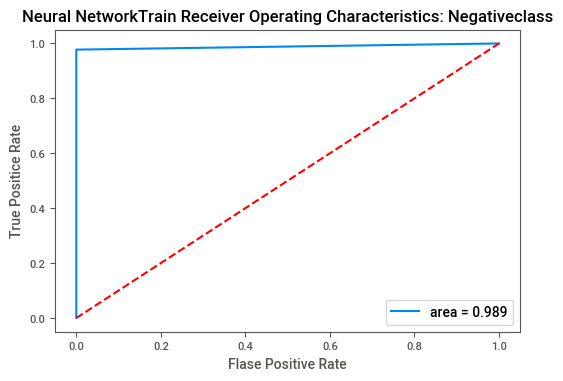

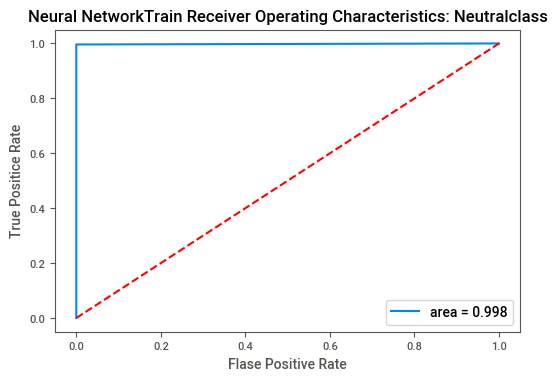

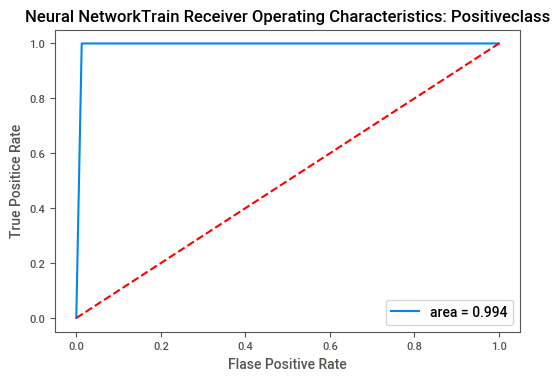


Roc AUC score test class Negative: 0.9887417218543046

Roc AUC score test class Neutral: 0.9981296758104738

Roc AUC score test class Positive: 0.993577392421323


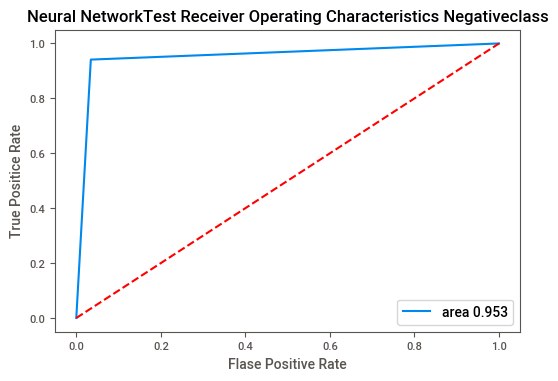

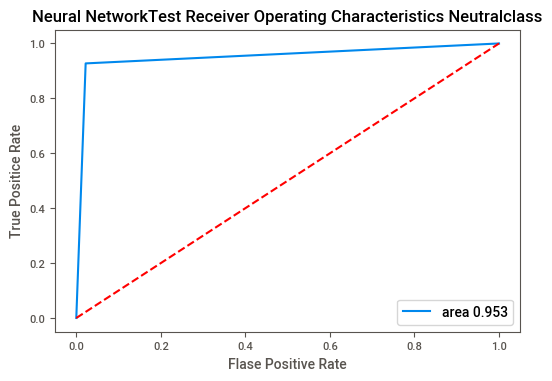

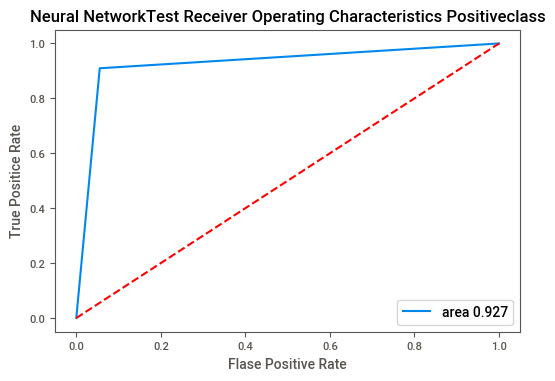

In [272]:
print('Neural Net Performance')
getPerformance(y_train, y_train_sc_pred_NN_decoded_labels, y_test, y_test_sc_pred_NN_decoded_labels, classes, 'Neural Network')

In [274]:
y_test_hid_sc_pred_NN = model.predict(x_test_hidden_vec_with_sc)
y_test_hid_sc_NN_labels = np.argmax(y_test_hid_sc_pred_NN, axis=-1)
y_test_hid_sc_NN_labels_decoded = decodeLabels(y_test_hid_sc_NN_labels)

print('Neural Net on Hidden data with sentiment score \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_test_hidden, y_test_hid_sc_NN_labels_decoded)))
print('Classification Report \n')
print(classification_report(y_test_hidden, y_test_hid_sc_NN_labels_decoded))

32/32 [==============================] - 1s 26ms/step
Neural Net on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.875 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.20      0.54      0.29        24
     Neutral       0.25      0.33      0.29        39
    Positive       0.96      0.91      0.93       937

    accuracy                           0.88      1000
   macro avg       0.47      0.59      0.50      1000
weighted avg       0.92      0.88      0.89      1000



##### Multinomial Naive Bayes classifier trained on balanced data and tested on hidden data 

Hidden data Test Accuracy score 0.853 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.21      0.54      0.31        24
     Neutral       0.18      0.41      0.25        39
    Positive       0.97      0.88      0.92       937

    accuracy                           0.85      1000
    macro avg      0.45      0.61      0.49      1000
    weighted avg   0.92      0.85      0.88      1000


##### Multinomial NB with Sentiment Score on Hidden data 

Hidden data Test Accuracy score 0.879 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.16      0.29      0.21        24
     Neutral       0.21      0.33      0.26        39
    Positive       0.96      0.92      0.94       937

    accuracy                           0.88      1000
    macro avg      0.44      0.51      0.47      1000
    weighted avg   0.91      0.88      0.89      1000

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Random Forest Classifier trained on balanced data and tested on hidden data 

Hidden data Test Accuracy score 0.903 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.57      0.17      0.26        24
     Neutral       0.14      0.18      0.16        39
    Positive       0.94      0.95      0.95       937

    accuracy                           0.90      1000
    macro avg      0.55      0.43      0.46      1000
    weighted avg   0.90      0.90      0.90      1000


Random Forest with Sentiment Score on Hidden data 

Hidden data Test Accuracy score 0.702 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.06      0.75      0.12        24
     Neutral       0.33      0.05      0.09        39
    Positive       0.96      0.73      0.83       937

    accuracy                           0.70      1000
    macro avg      0.45      0.51      0.34      1000
    weighted avg   0.92      0.70      0.78      1000

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### XGBoost Classifier on hidden data

XGboost on Hidden data 

Hidden data Test Accuracy score 0.913 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.64      0.29      0.40        24
     Neutral       0.24      0.33      0.28        39
    Positive       0.96      0.95      0.95       937

    accuracy                           0.91      1000
    macro avg      0.61      0.53      0.54      1000
    weighted avg   0.92      0.91      0.91      1000
 
 
##### XGBoost with Sentiment Score on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.873 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.19      0.50      0.28        24
     Neutral       0.22      0.33      0.27        39
    Positive       0.96      0.91      0.93       937

    accuracy                           0.87      1000
    macro avg      0.46      0.58      0.49      1000
    weighted avg   0.92      0.87      0.89      1000
    
#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Multi-class SVM - Linear SVC on Hidden data 

Hidden data Test Accuracy score 0.895 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.20      0.29      0.24        24
     Neutral       0.27      0.36      0.31        39
    Positive       0.96      0.93      0.94       937

    accuracy                           0.90      1000
    macro avg      0.48      0.53      0.50      1000
    weighted avg   0.91      0.90      0.90      1000


Multiclass Linear with Sentiment Score on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.898 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.23      0.50      0.31        24
     Neutral       0.30      0.33      0.31        39
    Positive       0.97      0.93      0.95       937

    accuracy                           0.90      1000
    macro avg      0.50      0.59      0.52      1000
    weighted avg   0.92      0.90      0.91      1000

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Neural Net on Hidden data 

Hidden data Test Accuracy score 0.873 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.15      0.29      0.20        24
     Neutral       0.22      0.38      0.28        39
    Positive       0.96      0.91      0.93       937

    accuracy                           0.87      1000
    macro avg      0.44      0.53      0.47      1000
    weighted avg   0.91      0.87      0.89      1000



##### Neural Net on Hidden data with sentiment score 

Neural Net on Hidden data with sentiment score 

Hidden data Test Accuracy score 0.875 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.20      0.54      0.29        24
     Neutral       0.25      0.33      0.29        39
    Positive       0.96      0.91      0.93       937

    accuracy                           0.88      1000
    macro avg      0.47      0.59      0.50      1000
    weighted avg   0.92      0.88      0.89      1000

#### After comparing the results on hidden test data on 
1. Multinomial Naive Bayes
2. Random Forest
3. XGboost
4. Multiclass SVM
5. Neural Net

#### It looks like adding sentiment score did not work well for Multinomial Naive Bayes and Tree based classifier but it improved the results for Multiclass SVM and Neural Net. 
#### So far Multiclass SVM with sentiment score and XGboost without sentiment score are the two models that have given better results that other in terms of overall f1-scores

### D. Applying LSTM

In [247]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [248]:
print(X.count())
print(y.count())
print(x_train_txt.shape)
print(y_train.shape)
print(x_test_txt.shape)
print(y_test.shape)

3402
3402
(2381,)
(2381,)
(1021,)
(1021,)


In [249]:
# # Preprocess the data
# tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
# tokenizer.fit_on_texts(df['text'])
# word_index = tokenizer.word_index
# sequences = tokenizer.texts_to_sequences(df['text'])
# padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post')
# input_sp = x_train_txt_vec.shape[1]

In [260]:
def preprocess_data_lstm(X):
    
    n_most_common_words = 8000
    max_len = 500
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(X.values)
    sequences = tokenizer.texts_to_sequences(X.values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X_pad_sequence = pad_sequences(sequences, maxlen=max_len)
    return X_pad_sequence

In [261]:
X_pad_sequence = preprocess_data_lstm(X)

Found 3235 unique tokens.


In [251]:
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 0, ..., 2, 1, 1])

In [252]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad_sequence , y_encoded, test_size=0.25, random_state=42)

In [253]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)

(2551, 500)
(2551,)


In [255]:
# Define the parameters
vocab_size = 10000   # n most common words
embedding_length = 128
max_length = X_train_lstm.shape[1]
num_layers = 1
dropout_rate = 0.2
epochs = 30
emb_dim = 128
batch_size = 32

# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_length, input_length=max_length))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Fit the model
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           24832     
                                                                 
 dropout_12 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_13 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_14 (Dropout)        (None, 64)               

In [256]:
# Model evaluation (SVM)
loss, accuracy = model_lstm.evaluate(X_test_lstm,y_test_lstm)

27/27 [==============================] - 4s 144ms/step - loss: 0.2724 - accuracy: 0.9260


In [257]:
y_train_lstm_pred_NN = model_lstm.predict(X_train_lstm)
y_test_lstm_pred_NN = model_lstm.predict(X_test_lstm)

27/27 [==============================] - 4s 131ms/step


In [258]:
y_train_lstm_pred_NN_labels = np.argmax(y_train_lstm_pred_NN, axis=-1)
y_test_lstm_pred_NN_labels = np.argmax(y_test_lstm_pred_NN, axis=-1)
print(y_train_lstm_pred_NN_labels[:10])
print(y_test_lstm_pred_NN_labels[:10])

y_train_lstm_pred_NN_decoded_labels = decodeLabels(y_train_lstm_pred_NN_labels)
y_test_lstm_pred_NN_decoded_labels = decodeLabels(y_test_lstm_pred_NN_labels)

print(y_train_lstm_pred_NN_decoded_labels[:10])
print(y_test_lstm_pred_NN_decoded_labels[:10])

y_train_lstm_decoded = decodeLabels(y_train_lstm)
y_test_lstm_decoded = decodeLabels(y_test_lstm)

[2 1 2 0 2 0 0 0 2 0]
[2 2 2 1 2 2 2 1 2 0]
['Positive' 'Neutral' 'Positive' 'Negative' 'Positive' 'Negative'
 'Negative' 'Negative' 'Positive' 'Negative']
['Positive' 'Positive' 'Positive' 'Neutral' 'Positive' 'Positive'
 'Positive' 'Neutral' 'Positive' 'Negative']


LSTM - Neural Net Performance
Accuracy score Train 0.9874558996471972
Accuracy score Test 0.9259694477085781

Train Classification Report: LSTM - Neural Network

              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00       837
     Neutral       0.98      0.99      0.99       846
    Positive       0.99      0.98      0.98       868

    accuracy                           0.99      2551
   macro avg       0.99      0.99      0.99      2551
weighted avg       0.99      0.99      0.99      2551


Test Classification Report: LSTM - Neural Network

              precision    recall  f1-score   support

    Negative       0.96      0.99      0.98       241
     Neutral       0.89      0.94      0.91       300
    Positive       0.94      0.86      0.90       310

    accuracy                           0.93       851
   macro avg       0.93      0.93      0.93       851
weighted avg       0.93      0.93      0.93       851


Train Confusion matrix:

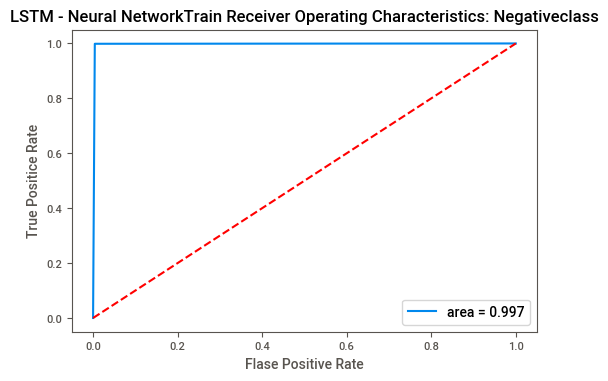

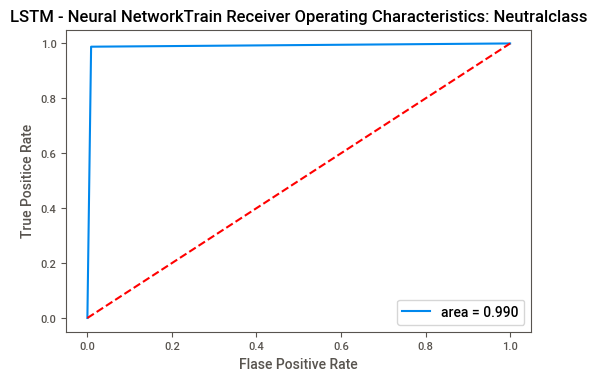

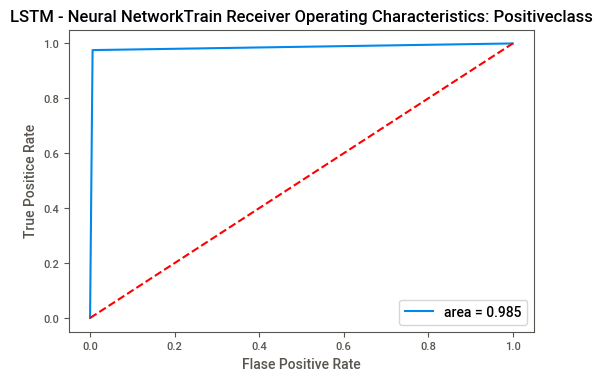


Roc AUC score test class Negative: 0.9973606214337196

Roc AUC score test class Neutral: 0.9896910075358943

Roc AUC score test class Positive: 0.9849323404826251


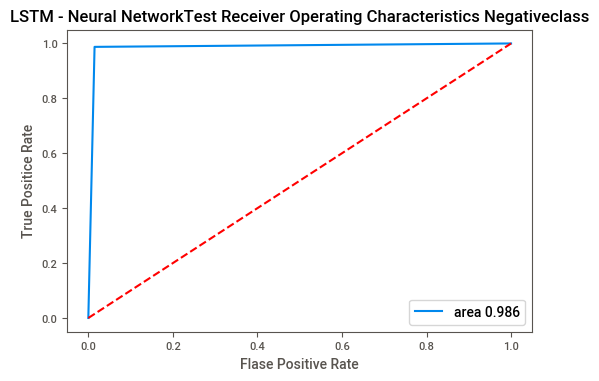

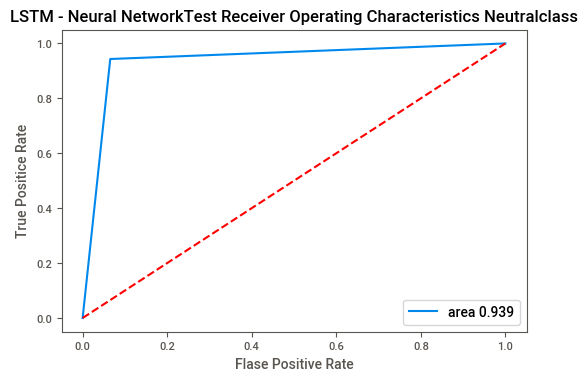

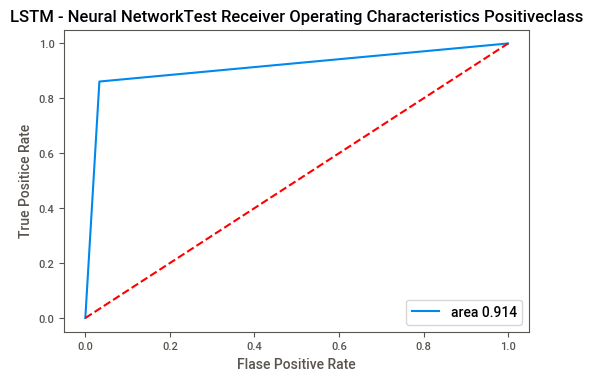

In [259]:
print('LSTM - Neural Net Performance')
getPerformance(y_train_lstm_decoded, y_train_lstm_pred_NN_decoded_labels, y_test_lstm_decoded, y_test_lstm_pred_NN_decoded_labels, classes, 'LSTM - Neural Network')

In [ ]:


y_test_hid_sc_pred_NN = model_lstm.predict(x_test_hidden_vec_with_sc)
y_train_hid_sc_NN_labels = np.argmax(y_test_hid_sc_pred_NN, axis=-1)
y_train_hid_sc_NN_labels_decoded = decodeLabels(y_train_hid_sc_NN_labels)



In [262]:
df_test_hidden.head()

,reviews_clean_text,sentiment
0,amazon kindl fire lot free app use one want ge...,Positive
1,echo show great addit amazon famili work like ...,Positive
2,great valu best buy bought christma sale,Positive
3,use mine email facebook game go line also load...,Positive
4,fantast item person bought love,Positive


In [263]:
X_hidden_lstm = df_test_hidden['reviews_clean_text']
y_hidden_lstm = df_test_hidden['sentiment']
print(X_hidden_lstm.count())
print(y_hidden_lstm.count())

1000
1000


In [264]:
X_hidden_lstm = preprocess_data_lstm(X_hidden_lstm)
y_hidden_lstm = le.fit_transform(y_hidden_lstm)

Found 2092 unique tokens.


In [287]:
y_hidden_predict_lstm = model_lstm.predict(X_hidden_lstm)

y_hidden_predict_lstm_labels = np.argmax(y_hidden_predict_lstm, axis=-1)
y_hidden_predict_lstm_decoded = decodeLabels(y_hidden_predict_lstm_labels)
y_hidden_lstm_decoded = decodeLabels(y_hidden_lstm)

print('LSTM - Neural Net on Hidden data \n')
print('Hidden data Test Accuracy score {} \n'.format(accuracy_score(y_hidden_lstm_decoded, y_hidden_predict_lstm_decoded)))
print('Classification Report \n')
print(classification_report(y_hidden_lstm_decoded, y_hidden_predict_lstm_decoded))

32/32 [==============================] - 5s 154ms/step
LSTM - Neural Net on Hidden data 

Hidden data Test Accuracy score 0.522 

Classification Report 

              precision    recall  f1-score   support

    Negative       0.03      0.21      0.05        24
     Neutral       0.03      0.26      0.06        39
    Positive       0.95      0.54      0.69       937

    accuracy                           0.52      1000
   macro avg       0.34      0.34      0.27      1000
weighted avg       0.89      0.52      0.65      1000



#### Using LSTM give much better results on Train and Test data for all the classes. But it did not scored well on hidden data. I need to fine tune the model.

### D. Topic Modeling

#### 7. Cluster similar reviews.

In [288]:
import nltk
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
stop_words = set(stopwords.words('english'))

Function to remove any emojis from the reviews

In [289]:
def cleanse_unicode(s):
    if not s:
        return ""
    
   # temp = single_quote_expr.sub("'", s, re.U)
    temp = emoji_pattern.sub("", s, re.U)
    return temp

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)


In [291]:
df = pd.read_csv('train_data.csv')
df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,Great easy tablet for a reasonable price. Not ...,"Nice tablet, simple to use",Positive
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-04T00:00:00.000Z,This is my second Kindle and I love it. It's l...,Everything you expect from Amazon,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,Tablet is perfect for beginners who just want ...,Ease of use,Positive
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2016-12-31T00:00:00.000Z,"Great quality, great price and best of all has...",Great deal,Positive


In [293]:
df = df.drop(['name', 'brand','categories', 'primaryCategories', 'reviews.date', 'reviews.title'], axis = 1)
df.head()

,reviews.text,sentiment
0,Great easy tablet for a reasonable price. Not ...,Positive
1,This is my second Kindle and I love it. It's l...,Positive
2,Just an average Alexa option. Does show a few ...,Neutral
3,Tablet is perfect for beginners who just want ...,Positive
4,"Great quality, great price and best of all has...",Positive


In [294]:
df.count()

reviews.text    1402
sentiment       1402
dtype: int64

In [296]:
df['reviews.text'] = df.apply(lambda x: remove_emoji(x['reviews.text']),axis=1)

Normalize casings for the review text and extract the text into a list for easier manipulation.

In [298]:
all_reviews = list(df['reviews.text'])
print(all_reviews[0])
all_reviews = [review.lower() for review in all_reviews]
print(all_reviews[0])

Great easy tablet for a reasonable price. Not the most super powerful. It can get the job done for simple tasks such as surfing the web, checking email, playing YouTube, etc. screen is clear and responsive. Great inexpensive tablet
great easy tablet for a reasonable price. not the most super powerful. it can get the job done for simple tasks such as surfing the web, checking email, playing youtube, etc. screen is clear and responsive. great inexpensive tablet


Tokenize the reviews using NLTKs word_tokenize function.

In [299]:
tokenized_reviews=[]
tokenized_reviews = [word_tokenize(review) for review in all_reviews]
tokenized_reviews[0]

['great',
 'easy',
 'tablet',
 'for',
 'a',
 'reasonable',
 'price',
 '.',
 'not',
 'the',
 'most',
 'super',
 'powerful',
 '.',
 'it',
 'can',
 'get',
 'the',
 'job',
 'done',
 'for',
 'simple',
 'tasks',
 'such',
 'as',
 'surfing',
 'the',
 'web',
 ',',
 'checking',
 'email',
 ',',
 'playing',
 'youtube',
 ',',
 'etc',
 '.',
 'screen',
 'is',
 'clear',
 'and',
 'responsive',
 '.',
 'great',
 'inexpensive',
 'tablet']

POS Tagging

In [300]:
pos_tagged_wordlist = []
pos_tagged_wordlist = [nltk.pos_tag(token_review) for token_review in tokenized_reviews]
pos_tagged_wordlist[0]

[('great', 'JJ'),
 ('easy', 'JJ'),
 ('tablet', 'NN'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('reasonable', 'JJ'),
 ('price', 'NN'),
 ('.', '.'),
 ('not', 'RB'),
 ('the', 'DT'),
 ('most', 'JJS'),
 ('super', 'JJ'),
 ('powerful', 'JJ'),
 ('.', '.'),
 ('it', 'PRP'),
 ('can', 'MD'),
 ('get', 'VB'),
 ('the', 'DT'),
 ('job', 'NN'),
 ('done', 'VBN'),
 ('for', 'IN'),
 ('simple', 'JJ'),
 ('tasks', 'NNS'),
 ('such', 'JJ'),
 ('as', 'IN'),
 ('surfing', 'VBG'),
 ('the', 'DT'),
 ('web', 'NN'),
 (',', ','),
 ('checking', 'VBG'),
 ('email', 'NN'),
 (',', ','),
 ('playing', 'VBG'),
 ('youtube', 'NN'),
 (',', ','),
 ('etc', 'FW'),
 ('.', '.'),
 ('screen', 'NN'),
 ('is', 'VBZ'),
 ('clear', 'JJ'),
 ('and', 'CC'),
 ('responsive', 'JJ'),
 ('.', '.'),
 ('great', 'JJ'),
 ('inexpensive', 'JJ'),
 ('tablet', 'NN')]

Function to get only Noun words

In [301]:
def GetNounPhrase(pos_tag_sent):    
    noun_phrase_list = ['NN','NNP','NNS','NNPS']
    count = 0
    noun_words = []
    # The pos_tagged_wordlist consist of multiple sentences. it is a List within a List.
#     for pos_tag_sent in pos_tagged_wordlist:
    for word,tag in pos_tag_sent:
#         if tag in noun_phrase_list and len(word) > 1:
        if tag in noun_phrase_list:
            count+=1
            noun_words.append(word.lower())
    
    return noun_words

In [302]:
words_noun_tags = [GetNounPhrase(pos_tag_sent) for pos_tag_sent in pos_tagged_wordlist]
words_noun_tags[0]

['tablet',
 'price',
 'job',
 'tasks',
 'web',
 'email',
 'youtube',
 'screen',
 'tablet']

Preprocessing Removing Stop words and Lemmetinzing already tokenized words

In [306]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...


True

In [307]:
# Remove Stop Words and Lemmatize 
lemmat = WordNetLemmatizer()
def preprocess(tokenized_text):
    preprocessed_text = []
    
    # 2. Remove Stopwords and words less then 3 characters
    cleaned_text = []
    for token in tokenized_text:
        if token not in stop_words and len(token) > 3:
            cleaned_text.append(token)
    
    # 3. Lemmatize
    for word in cleaned_text:
        lemmatized_word = lemmat.lemmatize(word , pos='n')
        preprocessed_text.append(word)
        
    
    return preprocessed_text

In [308]:
preprocessed_text = [preprocess(token_review) for token_review in tokenized_reviews]
print(preprocessed_text[0])

['great', 'easy', 'tablet', 'reasonable', 'price', 'super', 'powerful', 'done', 'simple', 'tasks', 'surfing', 'checking', 'email', 'playing', 'youtube', 'screen', 'clear', 'responsive', 'great', 'inexpensive', 'tablet']


Create a Dictionary of nouns from POS tagging.

In [ ]:
import gensim
from gensim.utils import simple_preprocess

In [310]:
# Create a Dictionary of nouns from POS tagging.
dictionary = gensim.corpora.Dictionary(words_noun_tags)
dictionary

# looking at first 20 items from the noun dictionary
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count +=1
    if count > 20:
        break

0 email
1 job
2 price
3 screen
4 tablet
5 tasks
6 web
7 youtube
8 bag
9 convenient
10 fits
11 i
12 kindle
13 trips
14 alexa
15 option
16 things
17 beginners
18 quality
19 sound
20 adults


Creating Bag of Words

In [311]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_text]
document_num = 1
bow_doc_x = bow_corpus[document_num]

bow_doc_x
for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], dictionary[bow_doc_x[i][0]], bow_doc_x[i][1]))

Word 9 ("convenient") appears 1 time.
Word 10 ("fits") appears 1 time.
Word 12 ("kindle") appears 1 time.
Word 13 ("trips") appears 1 time.
Word 407 ("love") appears 1 time.
Word 761 ("simple") appears 1 time.
Word 1424 ("fast") appears 1 time.
Word 1658 ("lightweight") appears 1 time.


#### 8. Perform Topic Modeling

Performing LDA with 10 topics

In [312]:
lda_model = gensim.models.LdaMulticore(corpus = bow_corpus,num_topics=10, id2word = dictionary, passes =10, workers = 2)

In [313]:
# For each topic, we will explore the words that occur in that topic and its relative weight:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.030*"kindle" + 0.026*"easy" + 0.021*"books" + 0.015*"purchase" + 0.015*"love" + 0.015*"money" + 0.012*"read" + 0.011*"light" + 0.011*"keeps" + 0.010*"screen"


Topic: 1 
Words: 0.040*"amazon" + 0.038*"echo" + 0.029*"show" + 0.024*"love" + 0.019*"kindle" + 0.018*"alexa" + 0.014*"home" + 0.013*"music" + 0.013*"generation" + 0.011*"sound"


Topic: 2 
Words: 0.067*"product" + 0.028*"easy" + 0.028*"good" + 0.021*"device" + 0.018*"screen" + 0.017*"price" + 0.014*"well" + 0.013*"tablet" + 0.013*"fire" + 0.013*"read"


Topic: 3 
Words: 0.069*"kindle" + 0.032*"love" + 0.022*"read" + 0.020*"loves" + 0.020*"reading" + 0.018*"screen" + 0.015*"books" + 0.012*"voyage" + 0.011*"light" + 0.011*"paperwhite"


Topic: 4 
Words: 0.112*"tablet" + 0.048*"loves" + 0.034*"kids" + 0.031*"year" + 0.029*"bought" + 0.028*"games" + 0.024*"easy" + 0.023*"good" + 0.021*"play" + 0.021*"apps"


Topic: 5 
Words: 0.044*"kids" + 0.038*"love" + 0.036*"bought" + 0.029*"time" + 0.023*"tablet" + 0.022*"app

Getting Coherence Score

In [314]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model = lda_model, texts = preprocessed_text, dictionary = dictionary, 
                                     coherence = 'c_v' )
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ",coherence_lda)

Coherence Score:  0.2863140326507246


#### Naming the 10 topics

* Topic 1 - Amazon Kindle book purchase and weight
* Topic 2 - Amazon Alexa music and sound
* Topic 3 - Fire Tablet - Value for money
* Topic 4 - Kindle Reading Experience
* Topic 5 - Tablet for Kids
* Topic 6 - Tablet as gift for kids
* Topic 7 - Parental Control in tablet
* Topic 8 - Kindle Screen and Size
* Topic 9 - Tablet Parents choice for kids
* Topic 10 - Battery and weight

Create a table with the topic name and the top 10 terms in each to present to the business.

In [315]:
topic_list = ['Amazon Kindle book purchase and weight', 'Amazon Alexa music and sound', 'Fire Tablet - Value for money', 
              'Kindle Reading Experience', 'Tablet for Kids', 'Tablet as gift for kids', 'Parental Control in tablet',
             'Kindle Screen and Size', 'Tablet Parents choice for kids', 'Battery and weight']

In [318]:
topic_word_list = []
data_test={}
for idx, topic in lda_model.print_topics(-1):
#     print(idx)
#     print(lda_model2.show_topic(idx))
    line_list = []
    for ww in range(0,10):
#         print(lda_model2.show_topic(idx)[ww][0])
        line_list.append(lda_model.show_topic(idx)[ww][0])
    topic_word_list.append(line_list)
    
    data_test[topic_list[idx]] = line_list
    

In [320]:
df_topic = pd.DataFrame(data = topic_list)

In [321]:
df_topic = pd.DataFrame(data_test)
df_topic

,Amazon Kindle book purchase and weight,Amazon Alexa music and sound,Fire Tablet - Value for money,Kindle Reading Experience,Tablet for Kids,Tablet as gift for kids,Parental Control in tablet,Kindle Screen and Size,Tablet Parents choice for kids,Battery and weight
0,kindle,amazon,product,kindle,tablet,kids,price,kindle,good,easy
1,easy,echo,easy,love,loves,love,bought,books,tablet,battery
2,books,show,good,read,kids,bought,parental,version,excellent,kindle
3,purchase,love,device,loves,year,time,pretty,read,item,reading
4,love,kindle,screen,reading,bought,tablet,slow,light,uses,light
5,money,alexa,price,screen,games,apps,tablet,thought,children,life
6,read,home,well,books,easy,amazon,controls,size,parental,read
7,light,music,tablet,voyage,good,product,love,purse,controls,good
8,keeps,generation,fire,light,play,well,good,tablet,easy,charge
9,screen,sound,read,paperwhite,apps,christmas,device,good,tablets,books
